# Impact analysis of COVID lockdowns on Airbnb Listings in Los Angeles
#### Author: Nandini Hegde
<h2 align="center">Part 2- Listings dataset</h2>

This project is part of the submission for UDACITY CRISP-DM Project.
The article explaining the findings is available at:

The aim of is this analysis is to assess the Bookings trend and impact on airbnb bookings/sales during the Covid lockdowns announced in early 2020 in comparison to the trends found during the same months in 2019

In this part of the analysis we will be **focused on the Listings dataset**. Part 1 of the analysis was focused on the calendars dataset and a few features were extracted and uploaded to BigQuery platformat for pivoting. Thar will be used in the analysis in the later half of this Notebook

### 2.0 Analysis Setup
Setting up libraries, reusable functions before we start the analysis.

**Importing required libraries**

In [3]:
#import libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import locale
import matplotlib.dates as mdates
import numpy as np
import matplotlib.cbook as cbook
import calendar


import datetime

from dask_ml.impute import SimpleImputer

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer

#Google cloud connectivity
import gcsfs
from google.cloud import storage
from IPython.core.display import display
import pandas_gbq

#import collections

import category_encoders as ce

#garbage collector to free memory
import gc
import pickle

from pprint import pprint
from sklearn.model_selection import GridSearchCV

**Frequently used functions**

In [2]:
#function to print large dataframe in limited space
def display_(df):     
    pd.set_option("display.max_rows", None)          
    display(df)
    
    
#function to reduce memory usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### 2.1 Data Reading and Cleaning of  of listings datasets

In [4]:
"""We have Airbnb listing and calendar bookings datasets which were scraped from the website from Jan 
to June both 2019 and 2020 for comparison
With each new month we can compare the changes in bookings/cancellations made on a particular date """

#Read the listing datasets alone first for EDA
#list of years and months when data was scraped

years=['2019','2020']
month_datascraped= ['Jan','Feb','March','April','May','June']
listings_2019={}
listings_2020={}
for year in years:
    for month in month_datascraped:
        filename=month+year
        print("Parsing dataset: "+ filename)
        if '2019' in year:
            url='gs://airbnblosangeles/Los Angeles_gcloud/Datasets_'+year+'/'+month+year+'/listings.csv'
            listings_2019[filename]=pd.read_csv(url)
            listings_2019[filename]['month_datascraped']=filename
        else:
            url='gs://airbnblosangeles/Los Angeles_gcloud/Datasets_'+year+'/'+month+year+'/listings.csv'
            listings_2020[filename]=pd.read_csv(url)
            listings_2020[filename]['month_datascraped']=filename



Parsing dataset: Jan2019


/home/hegdenandini/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Parsing dataset: Feb2019
Parsing dataset: March2019


/home/hegdenandini/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Parsing dataset: April2019
Parsing dataset: May2019
Parsing dataset: June2019
Parsing dataset: Jan2020
Parsing dataset: Feb2020
Parsing dataset: March2020
Parsing dataset: April2020
Parsing dataset: May2020
Parsing dataset: June2020


In [141]:
#check if all 6 datsets loaded
print('2019 files loaded:'+str(len(listings_2019)))
print('2020 files loaded:'+str(len(listings_2020)))

2019 files loaded:6
2020 files loaded:6


In [142]:
# Concat all the datasets for analysis

listing2019_df=pd.concat(listings_2019)
listing2020_df=pd.concat(listings_2020)

listing2020_df.head(2)

id                       listing_url       scrape_id last_scraped  \
Jan2020 0  109  https://www.airbnb.com/rooms/109  20200104042243   2020-01-04   
        1  344  https://www.airbnb.com/rooms/344  20200104042243   2020-01-05   

                                                        name  \
Jan2020 0  Amazing bright elegant condo park front *UPGRA...   
        1                  Family perfect;Pool;Near Studios!   

                                                     summary  \
Jan2020 0  *** Unit upgraded with new bamboo flooring, br...   
        1  This home is perfect for families; aspiring ch...   

                                                       space  \
Jan2020 0  *** Unit upgraded with new bamboo flooring, br...   
        1  Cheerful & comfortable; near studios, amusemen...   

                                                 description  \
Jan2020 0  *** Unit upgraded with new bamboo flooring, br...   
        1  This home is perfect for families; aspiring ch...   

          experiences_offered  \
Jan2020 0                none   
        1                none   

                                       neighborhood_overview  \
Jan2020 0                                                NaN   
        1  Quiet-yet-close to all the fun in LA! Hollywoo...   

                                                       notes  \
Jan2020 0                                                NaN   
        1  One dog may be on premises, friendly and cared...   

                                                     transit  \
Jan2020 0                                                NaN   
        1  Short drive to subway and elevated trains runn...   

                                                      access  \
Jan2020 0                                                NaN   
        1  Pool, patio and self-contained main house all ...   

                                                 interaction  \
Jan2020 0                                                NaN   
        1  Host and caretaker may be available throughout...   

                                                 house_rules  thumbnail_url  \
Jan2020 0  Camelot NEW RESIDENTS’ GENERAL INFORMATION   F...            nan   
        1  Host asks that guests refrain from partying lo...            nan   

           medium_url                                        picture_url  \
Jan2020 0         nan  https://a0.muscache.com/im/pictures/4321499/1d...   
        1         nan  https://a0.muscache.com/im/pictures/cc4b724d-d...   

           xl_picture_url  host_id                               host_url  \
Jan2020 0             nan      521  https://www.airbnb.com/users/show/521   
        1             nan      767  https://www.airbnb.com/users/show/767   

          host_name  host_since                             host_location  \
Jan2020 0     Paolo  2008-06-27  San Francisco, California, United States   
        1   Melissa  2008-07-11        Burbank, California, United States   

                                                  host_about  \
Jan2020 0  Search for me on the Internet with the keyword...   
        1  Single mother, CEO and Owner of an internation...   

          host_response_time host_response_rate host_acceptance_rate  \
Jan2020 0                NaN                NaN                  NaN   
        1       within a day               100%                  NaN   

          host_is_superhost  \
Jan2020 0                 f   
        1                 f   

                                          host_thumbnail_url  \
Jan2020 0  https://a0.muscache.com/im/users/521/profile_p...   
        1  https://a0.muscache.com/im/users/767/profile_p...   

                                            host_picture_url  \
Jan2020 0  https://a0.muscache.com/im/users/521/profile_p...   
        1  https://a0.muscache.com/im/users/767/profile_p...   

          host_neighbourhood  host_listings_count  host_total_listings_count  \
Jan2020 0        Culver City  

In [143]:
#check nulls
listing2019_df.isna().sum()

id                                                   0
listing_url                                          0
scrape_id                                            0
last_scraped                                         0
name                                                24
summary                                          10010
space                                            68599
description                                       5420
experiences_offered                                  0
neighborhood_overview                            90847
notes                                           129237
transit                                         101212
access                                           97866
interaction                                      97222
house_rules                                      79919
thumbnail_url                                   261925
medium_url                                      261925
picture_url                                          0
xl_picture

In [144]:
listing2020_df.isna().sum()

id                                                   0
listing_url                                          0
scrape_id                                            0
last_scraped                                         0
name                                                 9
summary                                          12633
space                                            59486
description                                       8733
experiences_offered                                  0
neighborhood_overview                            76834
notes                                           115236
transit                                          89374
access                                           97770
interaction                                      83718
house_rules                                      70725
thumbnail_url                                   227351
medium_url                                      227351
picture_url                                          0
xl_picture

In [145]:
#check memory usage

listing2019_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 261925 entries, ('Jan2019', 0) to ('June2019', 44477)
Columns: 107 entries, id to month_datascraped
dtypes: float64(22), int64(21), object(64)
memory usage: 2.0 GB


In [146]:
#release memory by deleting the contated lists
del listings_2019
del listings_2020

In [147]:
#Check dataset shape

listing2020_df.shape

(227351, 107)

In [148]:
#check column types
display_(listing2020_df.dtypes)


id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

In [150]:
#check range of numerical columns
pd.set_option('float_format', '{:f}'.format)
listing2019_df.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,261925.000000,261925.000000,0.000000,0.000000,0.000000,261925.000000,0.000000,261874.000000,261874.000000,261925.000000,261925.000000,261925.000000,261762.000000,261803.000000,261721.000000,2124.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,207975.000000,207854.000000,207861.000000,207669.000000,207821.000000,207636.000000,207588.000000,261925.000000,261925.000000,261925.000000,261925.000000,211380.000000
mean,19481326.698521,20190357101380.464844,nan,nan,nan,70161917.929293,nan,12.329326,12.329326,34.054653,-118.325565,3.655459,1.442946,1.412772,1.956175,977.421846,1.926128,5.472078,664.741693,5.287941,5.839263,663.371877,664.614069,5.608998,664.129617,12.171415,28.334344,46.321397,165.570808,30.352318,13.176806,94.474855,9.640387,9.435440,9.769431,9.757229,9.678240,9.468336,6.063892,4.148375,1.294928,0.620590,1.871003
std,9599633.596347,169728612.671911,nan,nan,nan,71394222.193062,nan,69.336955,69.336955,0.115267,0.152763,2.628528,0.929537,1.080246,1.647498,970.736183,1.740211,22.103084,4869.847203,21.816356,22.609434,4869.876532,4869.835262,22.192723,4869.837458,11.424728,22.933476,34.270591,136.265914,54.585676,20.298277,8.432023,0.830826,0.969036,0.711045,0.735173,0.719239,0.889375,13.915323,13.130453,3.466057,3.817836,1.946324
min,109.000000,20190111191840.000000,nan,nan,nan,59.000000,nan,0.000000,0.000000,33.338480,-118.934224,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,12521088.000000,20190203162918.000000,nan,nan,nan,11054072.000000,nan,1.000000,1.000000,34.011540,-118.421870,2.000000,1.000000,1.000000,1.000000,400.000000,1.000000,1.000000,30.000000,1.000000,1.000000,30.000000,30.000000,1.000000,30.000000,0.000000,1.000000,6.000000,33.000000,1.000000,0.000000,93.000000,9.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.380000
50%,20918445.000000,20190405205137.000000,nan,nan,nan,41117522.000000,nan,2.000000,2.000000,34.064300,-118.343270,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,2.000000,2.000000,1125.000000,1125.000000,2.000000,1125.000000,10.000000,29.000000,52.000000,145.000000,8.000000,4.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,0.000000,0.000000,1.150000
75%,27752612.000000,20190505154550.000000,nan,nan,nan,116813588.000000,nan,6.000000,6.000000,34.103432,-118.261420,5.000000,2.000000,2.000000,2.000000,1200.000000,2.000000,3.000000,1125.000000,3.000000,3.000000,1125.000000,1125.000000,3.000000,1125.000000,23.000000,51.000000,80.000000,312.000000,34.000000,18.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.000000,1.000000,0.000000,2.830000
max,35374058.000000,20190604174044.000000,nan,nan,nan,266206491.000000,na

In [151]:
#listing all numerical columns
print(listing2019_df.select_dtypes(exclude=['object']).columns.tolist())

['id', 'scrape_id', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_id', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']


In [154]:
#looking at numerical variables
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listing2019_df[listing2019_df.select_dtypes(exclude=['object']).columns.tolist()].head(3)

id       scrape_id  thumbnail_url  medium_url  xl_picture_url  \
Jan2019 0   109  20190111191840            nan         nan             nan   
        1   344  20190111191840            nan         nan             nan   
        2  2708  20190111191840            nan         nan             nan   

           host_id  host_acceptance_rate  host_listings_count  \
Jan2019 0      521                   nan             1.000000   
        1      767                   nan             1.000000   
        2     3008                   nan             2.000000   

           host_total_listings_count  latitude   longitude  accommodates  \
Jan2019 0                   1.000000 33.982095 -118.384935             6   
        1                   1.000000 34.165616 -118.334582             6   
        2                   2.000000 34.097676 -118.346023             1   

           bathrooms  bedrooms     beds  square_feet  guests_included  \
Jan2019 0   2.000000  2.000000 3.000000          nan                3   
        1   1.000000  3.000000 3.000000          nan                6   
        2   1.500000  1.000000 1.000000          nan                1   

           minimum_nights  maximum_nights  minimum_minimum_nights  \
Jan2019 0               7             730                       7   
        1               2              14                       2   
        2               6             366                       6   

           maximum_minimum_nights  minimum_maximum_nights  \
Jan2019 0                       7                     730   
        1                       2                      14   
        2                       6                     366   

           maximum_maximum_nights  minimum_nights_avg_ntm  \
Jan2019 0                     730                7.000000   
        1                      14                2.000000   
        2                     366                6.000000   

           maximum_nights_avg_ntm  availability_30  availability_60  \
Jan2019 0              730.000000                0                0   
        1               14.000000                0                0   
        2              366.000000                0                8   

           availability_90  availability_365  number_of_reviews  \
Jan2019 0                0               272                  2   
        1                0               169                  4   
        2               25               286                 14   

           number_of_reviews_ltm  review_scores_rating  \
Jan2019 0                      0             80.000000   
        1                      2             93.000000   
        2                      7             97.000000   

           review_scores_accuracy  review_scores_cleanliness  \
Jan2019 0               10.000000                  10.000000   
        1               10.000000                  10.000000   
        2               10.000000                  10.000000   

           review_scores_checkin  review_scores_communication  \
Jan2019 0               6.000000                     8.000000   
        1              10.000000                    10.000000   
        2              10.000000                    10.000000   

           review_scores_location  review_scores_value  \
Jan2019 0               10.000000             8.000000   
        1               10.000000             9.000000   
        2               10.000000            10.000000   

           calculated_host_listings_count  \
Jan2019 0                               1   
        1                               1   
        2                               2   

           calculated_host_listings_count_entire_homes  \
Jan2019 0                                            1   
        1                                            1   
        2                                            0   

           calculated_host_listings_count_private_rooms  \
Jan2019 0                                             0   
    

In [155]:
#listing at object variables
print(listing2019_df.select_dtypes(include=['object']).columns.tolist())

['listing_url', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'amenities', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated', 'has_availability', 'calendar_last_scraped', 'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'instant_bookable', 'is_business_travel_read

In [157]:
#looking at categorical variables
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listing2020_df[listing2020_df.select_dtypes(include=['object']).columns.tolist()].head(3)

listing_url last_scraped  \
Jan2020 0   https://www.airbnb.com/rooms/109   2020-01-04   
        1   https://www.airbnb.com/rooms/344   2020-01-05   
        2  https://www.airbnb.com/rooms/2708   2020-01-04   

                                                        name  \
Jan2020 0  Amazing bright elegant condo park front *UPGRA...   
        1                  Family perfect;Pool;Near Studios!   
        2  Mirrored Mini-Suite with Fireplace - W. Hollywood   

                                                     summary  \
Jan2020 0  *** Unit upgraded with new bamboo flooring, br...   
        1  This home is perfect for families; aspiring ch...   
        2  Our best memory foam pillows you'll ever sleep...   

                                                       space  \
Jan2020 0  *** Unit upgraded with new bamboo flooring, br...   
        1  Cheerful & comfortable; near studios, amusemen...   
        2  Flickering fireplace.  Blendtec® Designer 625 ...   

                                                 description  \
Jan2020 0  *** Unit upgraded with new bamboo flooring, br...   
        1  This home is perfect for families; aspiring ch...   
        2  Our best memory foam pillows you'll ever sleep...   

          experiences_offered  \
Jan2020 0                none   
        1                none   
        2                none   

                                       neighborhood_overview  \
Jan2020 0                                                NaN   
        1  Quiet-yet-close to all the fun in LA! Hollywoo...   
        2  We are minutes away from the Mentor Language I...   

                                                       notes  \
Jan2020 0                                                NaN   
        1  One dog may be on premises, friendly and cared...   
        2  Blendtec® Designer 625 Blender Bundle with Twi...   

                                                     transit  \
Jan2020 0                                                NaN   
        1  Short drive to subway and elevated trains runn...   
        2  There are many buses; bus stops going in every...   

                                                      access  \
Jan2020 0                                                NaN   
        1  Pool, patio and self-contained main house all ...   
        2  Kitchen with new refrigerator, dishwasher, sto...   

                                                 interaction  \
Jan2020 0                                                NaN   
        1  Host and caretaker may be available throughout...   
        2  I am friendly and available to help you with y...   

                                                 house_rules  \
Jan2020 0  Camelot NEW RESIDENTS’ GENERAL INFORMATION   F...   
        1  Host asks that guests refrain from partying lo...   
        2  I just have one rule. The Golden Rule Do unto ...   

                                                 picture_url  \
Jan2020 0  https://a0.muscache.com/im/pictures/4321499/1d...   
        1  https://a0.muscache.com/im/pictures/cc4b724d-d...   
        2  https://a0.muscache.com/im/pictures/40618141/2...   

                                         host_url host_name  host_since  \
Jan2020 0   https://www.airbnb.com/users/show/521     Paolo  2008-06-27   
        1   https://www.airbnb.com/users/show/767   Melissa  2008-07-11   
        2  https://www.airbnb.com/users/show/3008     Chas.  2008-09-16   

                                      host_location  \
Jan2020 0  San Francisco, California, United States   
        1        Burbank, California, United States   
        2    Los Angeles, California, United States   

                                                  host_about  \
Jan2020 0  Search for me on the Internet with the keyword...   
        1  Single mother, CEO and Owner of an internation...   
        2  Writer.\r\nLiterary Manager.\r\nPhotographer.\...   

          host_response_time host_response_rate h

In [158]:
 """Looking at the data in the various numerical and categorical columns,
 it is easy to identify certain variables that may not be useful for our analysis eg being thumbnail url,etc.
 So we will go ahead and eliminate those variables for simplification.
 We will also eliminate variables which might be useful but are simply more complicated for feature extraction 
 such as description,notes,etc"""

cols_to_drop = [col for col in listing2019_df.columns if 'url' in col]   
cols_to_drop.extend(['scrape_id', 'host_id',
                      'last_scraped', 'name', 'summary', 'space', 'description',
                      'host_name','street', 'neighbourhood','country_code', 'country','jurisdiction_names'])
print(cols_to_drop)


['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'scrape_id', 'host_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'host_name', 'street', 'neighbourhood', 'country_code', 'country', 'jurisdiction_names']


In [159]:
#deleting the columns should also release the memory
for col in cols_to_drop:
    del listing2019_df[col]
    del listing2020_df[col]

In [160]:
#ensuring both the datasets have the same set of columns
list(set(listing2020_df.columns) - set(listing2019_df.columns))

[]

In [165]:
#remove $,% sign from all object variables that can be converted to numeric 
for col in listing2019_df.select_dtypes(include=['object']).columns:
    if any(x in col for x in ["price","fee","deposit","extra","rate"]):
        print(col)
        listing2020_df[col] = listing2020_df[col].str.replace(r'[^\d.]', '').astype('float16')
        listing2019_df[col] = listing2019_df[col].str.replace(r'[^\d.]', '').astype('float16')



host_response_rate
price
weekly_price
monthly_price
security_deposit
cleaning_fee
extra_people


In [167]:
#looking at remaining object variables
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listing2020_df[listing2020_df.select_dtypes(include=['object']).columns.tolist()].shape
listing2020_df[listing2020_df.select_dtypes(include=['object']).columns.tolist()].head(3)

experiences_offered  \
Jan2020 0                none   
        1                none   
        2                none   

                                       neighborhood_overview  \
Jan2020 0                                                NaN   
        1  Quiet-yet-close to all the fun in LA! Hollywoo...   
        2  We are minutes away from the Mentor Language I...   

                                                       notes  \
Jan2020 0                                                NaN   
        1  One dog may be on premises, friendly and cared...   
        2  Blendtec® Designer 625 Blender Bundle with Twi...   

                                                     transit  \
Jan2020 0                                                NaN   
        1  Short drive to subway and elevated trains runn...   
        2  There are many buses; bus stops going in every...   

                                                      access  \
Jan2020 0                                                NaN   
        1  Pool, patio and self-contained main house all ...   
        2  Kitchen with new refrigerator, dishwasher, sto...   

                                                 interaction  \
Jan2020 0                                                NaN   
        1  Host and caretaker may be available throughout...   
        2  I am friendly and available to help you with y...   

                                                 house_rules  host_since  \
Jan2020 0  Camelot NEW RESIDENTS’ GENERAL INFORMATION   F...  2008-06-27   
        1  Host asks that guests refrain from partying lo...  2008-07-11   
        2  I just have one rule. The Golden Rule Do unto ...  2008-09-16   

                                      host_location  \
Jan2020 0  San Francisco, California, United States   
        1        Burbank, California, United States   
        2    Los Angeles, California, United States   

                                                  host_about  \
Jan2020 0  Search for me on the Internet with the keyword...   
        1  Single mother, CEO and Owner of an internation...   
        2  Writer.\r\nLiterary Manager.\r\nPhotographer.\...   

          host_response_time host_acceptance_rate host_is_superhost  \
Jan2020 0                NaN                  NaN                 f   
        1       within a day                  NaN                 f   
        2     within an hour                  NaN                 t   

          host_neighbourhood  \
Jan2020 0        Culver City   
        1            Burbank   
        2          Hollywood   

                                          host_verifications  \
Jan2020 0   ['email', 'phone', 'facebook', 'reviews', 'kba']   
        1  ['email', 'phone', 'reviews', 'jumio', 'kba', ...   
        2   ['email', 'phone', 'facebook', 'reviews', 'kba']   

          host_has_profile_pic host_identity_verified neighbourhood_cleansed  \
Jan2020 0                    t                      t            Culver City   
        1                    t                      t                Burbank   
        2                    t                      t              Hollywood   

          neighbourhood_group_cleansed         city state zipcode  \
Jan2020 0                 Other Cities  Culver City    CA   90230   
        1                 Other Cities      Burbank    CA   91505   
        2          City of Los Angeles  Los Angeles    CA   90046   

                market   smart_location is_location_exact property_type  \
Jan2020 0  Los Angeles  Culver City, CA                 t   Condominium   
        1  Los Angeles      Burbank, CA                 t         House   
        2  Los Angeles  Los Angeles, CA                 t     Apartment   

                 room_type  bed_type  \
Jan2020 0  Entire home/apt  Real Bed   
        1  Entire home/apt  Real Bed   
        2     Private room  Real Bed   

                                                   amenities calendar_updated 

In [168]:
#looking at the shape of datatsets
listing2020_df[listing2020_df.select_dtypes(include=['object']).columns.tolist()].shape

(227351, 42)

In [169]:
#Reviewing all numerical columns
listing2020_df[listing2020_df.select_dtypes(exclude=['object']).columns.tolist()].head(3)

id  host_response_rate  host_listings_count  \
Jan2020 0   109                 nan             1.000000   
        1   344          100.000000             1.000000   
        2  2708          100.000000             2.000000   

           host_total_listings_count  latitude   longitude  accommodates  \
Jan2020 0                   1.000000 33.982090 -118.384940             6   
        1                   1.000000 34.165620 -118.334580             6   
        2                   2.000000 34.097680 -118.346020             1   

           bathrooms  bedrooms     beds  square_feet      price  weekly_price  \
Jan2020 0   2.000000  2.000000 3.000000          nan 122.000000    904.000000   
        1   1.000000  3.000000 3.000000          nan 168.000000           nan   
        2   1.500000  1.000000 1.000000          nan  79.000000    399.000000   

           monthly_price  security_deposit  cleaning_fee  guests_included  \
Jan2020 0    2852.000000        500.000000    240.000000                3   
        1            nan          0.000000    100.000000                6   
        2     949.000000        450.000000     84.000000                1   

           extra_people  minimum_nights  maximum_nights  \
Jan2020 0     25.000000              30             730   
        1      0.000000               2              14   
        2      0.000000              30             366   

           minimum_minimum_nights  maximum_minimum_nights  \
Jan2020 0                      30                      30   
        1                       2                       2   
        2                      30                      30   

           minimum_maximum_nights  maximum_maximum_nights  \
Jan2020 0                     730                     730   
        1                      14                      14   
        2                    1125                    1125   

           minimum_nights_avg_ntm  maximum_nights_avg_ntm  availability_30  \
Jan2020 0               30.000000              730.000000                0   
        1                2.000000               14.000000                0   
        2               30.000000             1125.000000                7   

           availability_60  availability_90  availability_365  \
Jan2020 0                0                2               277   
        1                0                0                 0   
        2               19               19               281   

           number_of_reviews  number_of_reviews_ltm  review_scores_rating  \
Jan2020 0                  2                      0             80.000000   
        1                  8                      2             97.000000   
        2                 23                      9             98.000000   

           review_scores_accuracy  review_scores_cleanliness  \
Jan2020 0               10.000000                  10.000000   
        1               10.000000                  10.000000   
        2               10.000000                  10.000000   

           review_scores_checkin  review_scores_communication  \
Jan2020 0               6.000000                     8.000000   
        1              10.000000                    10.000000   
        2              10.000000                    10.000000   

           review_scores_location  review_scores_value  \
Jan2020 0               10.000000             8.000000   
        1               10.000000            10.000000   
        2               10.000000            10.000000   

           calculated_host_listings_count  \
Jan2020 0                               1   
        1                               1   
        2                               2   

           calculated_host_listings_count_entire_homes  \
Jan2020 0                                            1   
        1                                            1   
        2                                            0   

           calculated_host_listings_count_private_rooms  \

### 2.2 Feature extraction from listings dataset

In [170]:
#converting all date like variables back to date format and extracting a numerical feature from them 
listing2019_df['host_since'] = pd.to_datetime(listing2019_df['host_since'].astype('object'))
listing2020_df['host_since'] = pd.to_datetime(listing2020_df['host_since'].astype('object'))

listing2019_df['calendar_last_scraped'] = pd.to_datetime(listing2019_df['calendar_last_scraped'].astype('object'))
listing2020_df['calendar_last_scraped'] = pd.to_datetime(listing2020_df['calendar_last_scraped'].astype('object'))
listing2019_df['first_review'] = pd.to_datetime(listing2019_df['first_review'].astype('object'))
listing2020_df['first_review'] = pd.to_datetime(listing2020_df['first_review'].astype('object'))
listing2019_df['last_review'] = pd.to_datetime(listing2019_df['last_review'].astype('object'))
listing2020_df['last_review'] = pd.to_datetime(listing2020_df['last_review'].astype('object'))

#convert to a relative numerical variable from current date
listing2019_df['host_since'] = (datetime.today()-listing2019_df['host_since']).dt.days
listing2020_df['host_since'] = (datetime.today()-listing2020_df['host_since']).dt.days

listing2019_df['calendar_last_scraped'] = (datetime.today()-listing2019_df['calendar_last_scraped']).dt.days
listing2020_df['calendar_last_scraped'] = (datetime.today()-listing2020_df['calendar_last_scraped']).dt.days

listing2019_df['first_review'] = (datetime.today()-listing2019_df['first_review']).dt.days
listing2020_df['first_review'] = (datetime.today()-listing2020_df['first_review']).dt.days

listing2019_df['last_review'] = (datetime.today()-listing2019_df['last_review']).dt.days
listing2020_df['last_review'] = (datetime.today()-listing2020_df['last_review']).dt.days



In [171]:
# Review numerical columns again
listing2020_df[listing2020_df.select_dtypes(exclude=['object']).columns.tolist()].head(3)

id  host_since  host_response_rate  host_listings_count  \
Jan2020 0   109 4452.000000                 nan             1.000000   
        1   344 4438.000000          100.000000             1.000000   
        2  2708 4371.000000          100.000000             2.000000   

           host_total_listings_count  latitude   longitude  accommodates  \
Jan2020 0                   1.000000 33.982090 -118.384940             6   
        1                   1.000000 34.165620 -118.334580             6   
        2                   2.000000 34.097680 -118.346020             1   

           bathrooms  bedrooms     beds  square_feet      price  weekly_price  \
Jan2020 0   2.000000  2.000000 3.000000          nan 122.000000    904.000000   
        1   1.000000  3.000000 3.000000          nan 168.000000           nan   
        2   1.500000  1.000000 1.000000          nan  79.000000    399.000000   

           monthly_price  security_deposit  cleaning_fee  guests_included  \
Jan2020 0    2852.000000        500.000000    240.000000                3   
        1            nan          0.000000    100.000000                6   
        2     949.000000        450.000000     84.000000                1   

           extra_people  minimum_nights  maximum_nights  \
Jan2020 0     25.000000              30             730   
        1      0.000000               2              14   
        2      0.000000              30             366   

           minimum_minimum_nights  maximum_minimum_nights  \
Jan2020 0                      30                      30   
        1                       2                       2   
        2                      30                      30   

           minimum_maximum_nights  maximum_maximum_nights  \
Jan2020 0                     730                     730   
        1                      14                      14   
        2                    1125                    1125   

           minimum_nights_avg_ntm  maximum_nights_avg_ntm  availability_30  \
Jan2020 0               30.000000              730.000000                0   
        1                2.000000               14.000000                0   
        2               30.000000             1125.000000                7   

           availability_60  availability_90  availability_365  \
Jan2020 0                0                2               277   
        1                0                0                 0   
        2               19               19               281   

           calendar_last_scraped  number_of_reviews  number_of_reviews_ltm  \
Jan2020 0                    244                  2                      0   
        1                    243                  8                      2   
        2                    244                 23                      9   

           first_review  last_review  review_scores_rating  \
Jan2020 0   3308.000000  1573.000000             80.000000   
        1   1543.000000   321.000000             97.000000   
        2   2279.000000   267.000000             98.000000   

           review_scores_accuracy  review_scores_cleanliness  \
Jan2020 0               10.000000                  10.000000   
        1               10.000000                  10.000000   
        2               10.000000                  10.000000   

           review_scores_checkin  review_scores_communication  \
Jan2020 0               6.000000                     8.000000   
        1              10.000000                    10.000000   
        2              10.000000                    10.000000   

           review_scores_location  review_scores_value  \
Jan2020 0               10.000000             8.000000   
        1               10.000000            10.000000   
        2               10.000000            10.000000   

           calculated_host_listings_count  \
Jan2020 0                               1   
        1                               1   
        2                           

In [198]:
#Dropping all indexes
listing2019_df=listing2019_df.reset_index(drop=True)
listing2020_df=listing2020_df.reset_index(drop=True)

In [203]:
# Extracting features from calendar updated variables
listing2019_df.loc[listing2019_df['calendar_updated'].notna(),'calendar_updated_since']=listing2019_df.loc[listing2019_df['calendar_updated'].notna(),'calendar_updated'].str.extract('(\d+)').astype('float16').to_numpy()
listing2020_df.loc[listing2020_df['calendar_updated'].notna(),'calendar_updated_since']=listing2020_df.loc[listing2020_df['calendar_updated'].notna(),'calendar_updated'].str.extract('(\d+)').astype('float16').to_numpy()

keywords=['year','week','months','today','yesterday','never']
for word in keywords:
    #print(listing2019_df.loc[listing2019_df['calendar_updated'].notna(),'calendar_updated'].str.extract('(\d+)').astype('float16').head())
    listing2019_df.loc[listing2019_df['calendar_updated'].str.contains(word),'calendar_updated_timeslab']=word
    listing2020_df.loc[listing2020_df['calendar_updated'].str.contains(word),'calendar_updated_timeslab']=word
listing2019_df[['calendar_updated','calendar_updated_since','calendar_updated_timeslab']].head()

,calendar_updated,calendar_updated_since,calendar_updated_timeslab
0,10 months ago,10.000000,months
1,a week ago,nan,week
2,today,nan,today
3,2 months ago,2.000000,months
4,6 months ago,6.000000,months


In [228]:
#Dropping certain features for simplicity
listing2019_df=listing2019_df.drop(['host_acceptance_rate_clean','host_acceptance_rate','calendar_updated'],axis=1)
listing2020_df=listing2020_df.drop(['host_acceptance_rate_clean','host_acceptance_rate','calendar_updated'],axis=1)
listing2020_df.head()

,id,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,month_datascraped,calendar_updated_since,calendar_updated_timeslab
0,109,none,NaN,NaN,NaN,NaN,NaN,Camelot NEW RESIDENTS’ GENERAL INFORMATION F...,4452.000000,"San Francisco, California, United States",Search for me on the Internet with the keyword...,NaN,nan,f,Culver City,1.000000,1.000000,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,Culver City,Other Cities,Culver City,CA,90230,Los Angeles,"Culver City, CA",33.982090,-118.384940,t,Condominium,Entire home/apt,6,2.000000,2.000000,3.000000,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",nan,122.000000,904.000000,2852.000000,500.000000,240.000000,3,25.000000,30,730,30,30,730,730,30.000000,730.000000,t,0,0,2,277,244,2,0,3308.000000,1573.000000,80.000000,10.000000,10.000000,6.000000,8.000000,10.000000,8.000000,f,NaN,f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.020000,Jan2020,11.000000,months
1,344,none,Quiet-yet-close to all the fun in LA! Hollywoo...,"One dog may be on premises, friendly and cared...",Short drive to subway and elevated trains runn...,"Pool, patio and self-contained main house all ...",Host and caretaker may be available throughout...,Host asks that guests refrain from partying lo...,4438.000000,"Burbank, California, United States","Single mother, CEO and Owner of an internation...",within a day,100.000000,f,Burbank,1.000000,1.000000,"['email', 'phone', 'reviews', 'jumio', 'kba', ...",t,t,Burbank,Other Cities,Burbank,CA,91505,Los Angeles,"Burbank, CA",34.165620,-118.334580,t,House,Entire home/apt,6,1.000000,3.000000,3.000000,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",nan,168.000000,nan,nan,0.000000,100.000000,6,0.000000,2,14,2,2,14,14,2.000000,14.000000,t,0,0,0,0,243,8,2,1543.000000,321.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,f,NaN,t,f,flexible,f,f,1,1,0,0,0.180000,Jan2020,3.000000,months
2,2708,none,We are minutes away from the Mentor Language I...,Blendtec® Designer 625 Blender Bundle with Twi...,There are many buses; bus stops going in every...,"Kitchen with new refrigerator, dishwasher, sto...",I am friendly and available to help you with y...,I just have one rule. The Golden Rule Do unto ...,4371.000000,"Los Angeles, California, United States",Writer.\r\nLiterary Manager.\r\nPhotographer.\...,within an hour,100.000000,t,Hollywood,2.000000,2.000000,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,Hollywood,City of Los Angeles,Los Angeles,CA,90046,Los Angeles,"Los Angeles, CA",34.097680,-118.346020,t,Apartment,Private room,1,1.500000,1.000000,1

In [230]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#looking at only categorical attributes
cat_features = listing2020_df.select_dtypes(include=['object']).columns.tolist()

#seperate binary and multi level feature
binary_feature = []
multi_feature=[]
for feature in cat_features:
    #three because even Nan is being counted 
    if (len(listing2020_df[feature].unique())==3):
        binary_feature.append(feature)
    elif (len(listing2020_df[feature].unique())>3):
        multi_feature.append(feature)
        
print("Categorical attributes with Binary features: {}".format(len(binary_feature)))

print("Categorical attributes with Multi level features: {}".format(len(multi_feature)))


Categorical attributes with Binary features: 4
Categorical attributes with Multi level features: 25


In [231]:
listing2020_df[binary_feature].head(2)

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed
0,f,t,t,Other Cities
1,f,t,t,Other Cities


In [232]:
listing2020_df[multi_feature].head(2)

,neighborhood_overview,notes,transit,access,interaction,house_rules,host_location,host_about,host_response_time,host_neighbourhood,host_verifications,neighbourhood_cleansed,city,state,zipcode,market,smart_location,property_type,room_type,bed_type,amenities,license,cancellation_policy,month_datascraped,calendar_updated_timeslab
0,NaN,NaN,NaN,NaN,NaN,Camelot NEW RESIDENTS’ GENERAL INFORMATION F...,"San Francisco, California, United States",Search for me on the Internet with the keyword...,NaN,Culver City,"['email', 'phone', 'facebook', 'reviews', 'kba']",Culver City,Culver City,CA,90230,Los Angeles,"Culver City, CA",Condominium,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,strict_14_with_grace_period,Jan2020,months
1,Quiet-yet-close to all the fun in LA! Hollywoo...,"One dog may be on premises, friendly and cared...",Short drive to subway and elevated trains runn...,"Pool, patio and self-contained main house all ...",Host and caretaker may be available throughout...,Host asks that guests refrain from partying lo...,"Burbank, California, United States","Single mother, CEO and Owner of an internation...",within a day,Burbank,"['email', 'phone', 'reviews', 'jumio', 'kba', ...",Burbank,Burbank,CA,91505,Los Angeles,"Burbank, CA",House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,flexible,Jan2020,months


#### Looking closely at columns which contains lists such as 'amenities' and 'host_verifications' **

In [234]:
#creating a unique list of all forms of host verifications 
host_verifications=[]
for ver in listing2020_df.host_verifications.unique():
    host_verifications.extend(ver.strip('][').replace("'","").replace(" ","").split(','))

for ver in listing2019_df.host_verifications.unique():
    host_verifications.extend(ver.strip('][').replace("'","").replace(" ","").split(','))
host_verifications=set(host_verifications)
print(len(host_verifications))
print(host_verifications)

22
{'', 'manual_offline', 'photographer', 'zhima_selfie', 'weibo', 'kba', 'email', 'reviews', 'sesame', 'identity_manual', 'work_email', 'jumio', 'facebook', 'sesame_offline', 'google', 'government_id', 'selfie', 'offline_government_id', 'manual_online', 'None', 'phone', 'sent_id'}


In [235]:
#convert the list of host verifications and amenities into to individual feature column
host_verifications.remove('')
for ver in host_verifications:

    col_name='hostver_'+ver
    print('Creating column: '+ col_name)
    listing2019_df.loc[listing2019_df['host_verifications'].str.contains(ver),col_name]='t'
    listing2019_df.loc[~listing2019_df['host_verifications'].str.contains(ver),col_name]='f'
    listing2020_df.loc[listing2020_df['host_verifications'].str.contains(ver),col_name]='t'
    listing2020_df.loc[~listing2020_df['host_verifications'].str.contains(ver),col_name]='f'


Creating column: hostver_manual_offline
Creating column: hostver_photographer
Creating column: hostver_zhima_selfie
Creating column: hostver_weibo
Creating column: hostver_kba
Creating column: hostver_email
Creating column: hostver_reviews
Creating column: hostver_sesame
Creating column: hostver_identity_manual
Creating column: hostver_work_email
Creating column: hostver_jumio
Creating column: hostver_facebook
Creating column: hostver_sesame_offline
Creating column: hostver_google
Creating column: hostver_government_id
Creating column: hostver_selfie
Creating column: hostver_offline_government_id
Creating column: hostver_manual_online
Creating column: hostver_None
Creating column: hostver_phone
Creating column: hostver_sent_id


In [236]:
## Action: conversion of dtype from "object" to "category" to save memory
for ver in host_verifications:
    col_name='hostver_'+ver
    listing2019_df[col_name] = listing2019_df[col_name].astype('category')
    listing2020_df[col_name] = listing2020_df[col_name].astype('category')
    
listing2020_df.head(2)

,id,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,month_datascraped,calendar_updated_since,calendar_updated_timeslab,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id
0,109,none,NaN,NaN,NaN,NaN,NaN,Camelot NEW RESIDENTS’ GENERAL INFORMATION F...,4452.000000,"San Francisco, California, United States",Search for me on the Internet with the keyword...,NaN,nan,f,Culver City,1.000000,1.000000,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,Culver City,Other Cities,Culver City,CA,90230,Los Angeles,"Culver City, CA",33.982090,-118.384940,t,Condominium,Entire home/apt,6,2.000000,2.000000,3.000000,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",nan,122.000000,904.000000,2852.000000,500.000000,240.000000,3,25.000000,30,730,30,30,730,730,30.000000,730.000000,t,0,0,2,277,244,2,0,3308.000000,1573.000000,80.000000,10.000000,10.000000,6.000000,8.000000,10.000000,8.000000,f,NaN,f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.020000,Jan2020,11.000000,months,f,f,f,f,t,t,t,f,f,f,f,t,f,f,f,f,f,f,f,t,f
1,344,none,Quiet-yet-close to all the fun in LA! Hollywoo...,"One dog may be on premises, friendly and cared...",Short drive to subway and elevated trains runn...,"Pool, patio and self-contained main house all ...",Host and caretaker may be available throughout...,Host asks that guests refrain from partying lo...,4438.000000,"Burbank, California, United States","Single mother, CEO and Owner of an internation...",within a day,100.000000,f,Burbank,1.000000,1.000000,"['email', 'phone', 'reviews', 'jumio', 'kba', ...",t,t,Burbank,Other Cities,Burbank,CA,91505,Los Angeles,"Burbank, CA",34.165620,-118.334580,t,House,Entire home/apt,6,1.000000,3.000000,3.000000,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",nan,168.000000,nan,nan,0.000000,100.000000,6,0.000000,2,14,2,2,14,14,2.000000,14.000000,t,0,0,0,0,243,8,2,1543.000000,321.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,f,NaN,t,f,flexible,f,f,1,1,0,0,0.180000,Jan2020,3.000000,months,f,f,f,f,t,t,t,f,f,f,t,f,f,f,t,f,f,f,f,t,f


In [237]:
#check dataset details
listing2019_df.isna().sum()

id                                                   0
experiences_offered                                  0
neighborhood_overview                            90847
notes                                           129237
transit                                         101212
access                                           97866
interaction                                      97222
house_rules                                      79919
host_since                                          51
host_location                                      925
host_about                                       89789
host_response_time                               61166
host_response_rate                               61166
host_is_superhost                                   51
host_neighbourhood                               48056
host_listings_count                                 51
host_total_listings_count                           51
host_verifications                                   0
host_has_p

In [238]:
#creating a unique list of all forms of amenities
pd.set_option('display.max_columns', 100)
amenities=[]
for ver in listing2020_df.amenities.unique():
    amenities.extend(list(set(ver.strip('}{').replace('"','').split(','))))
    amenities=list(set(amenities))

for ver in listing2019_df.amenities.unique():
    amenities.extend(list(set(ver.strip('}{').replace('"','').split(','))))
    amenities=list(set(amenities))
amenities=list(set(amenities))
print(len(amenities))
print(amenities)

375
['', 'Ironing board', 'Dual vanity', 'Room service', 'Shampoo', 'Steam oven', 'Lap pool', 'Safety card', 'Driveway parking', 'Alfresco shower', 'Wide doorway to guest bathroom', 'Flat path to front door', 'Accessible-height bed', 'Smart lock', 'Breakfast', 'Carbon monoxide detector', 'Mini fridge', 'Terrace', 'Shared gym', 'Building staff', 'Buzzer/wireless intercom', 'Sound system', 'Outdoor parking', 'Play Room', 'Walk in closet', 'Hand soap', 'Firm mattress', 'Large mirror', 'Dishwasher', 'Lounge area', 'HBO GO', 'Wide entrance', 'Shower gel', 'Step-free access', 'Smoking allowed', 'Dog(s)', 'DVD player', 'Bed linens', 'Piano', 'Essentials', 'Foosball table', 'Pillow-top mattress', 'Shower bathtub combo', 'Touchless faucets', 'Espresso machine', 'Fixed grab bars for shower', 'Paid parking on premises', 'Soaking tub', 'Indoor fireplace', 'Basketball court', 'Gazebo', 'Charcoal barbeque', 'Gym', 'Lounge chairs', 'Shared pool', 'Ceiling hoist', 'Wide hallway clearance', 'Wood-burni

In [239]:
#convert the list of amenities into to individual feature column
pd.set_option('display.max_columns', 100)
amenities.remove('')
count=1

for ver in amenities:

    col_name='amenities_'+ver
    print(str(count)+'. Creating column: '+ col_name)
    count+=1
    listing2019_df.loc[listing2019_df['amenities'].str.contains(ver),col_name]='t'
    listing2019_df.loc[~listing2019_df['amenities'].str.contains(ver),col_name]='f'
    listing2020_df.loc[listing2020_df['amenities'].str.contains(ver),col_name]='t'
    listing2020_df.loc[~listing2020_df['amenities'].str.contains(ver),col_name]='f'


1. Creating column: amenities_Ironing board
2. Creating column: amenities_Dual vanity
3. Creating column: amenities_Room service
4. Creating column: amenities_Shampoo
5. Creating column: amenities_Steam oven
6. Creating column: amenities_Lap pool
7. Creating column: amenities_Safety card
8. Creating column: amenities_Driveway parking
9. Creating column: amenities_Alfresco shower
10. Creating column: amenities_Wide doorway to guest bathroom
11. Creating column: amenities_Flat path to front door
12. Creating column: amenities_Accessible-height bed
13. Creating column: amenities_Smart lock
14. Creating column: amenities_Breakfast
15. Creating column: amenities_Carbon monoxide detector
16. Creating column: amenities_Mini fridge
17. Creating column: amenities_Terrace
18. Creating column: amenities_Shared gym
19. Creating column: amenities_Building staff
20. Creating column: amenities_Buzzer/wireless intercom
21. Creating column: amenities_Sound system
22. Creating column: amenities_Outdoor 

/home/hegdenandini/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


36. Creating column: amenities_DVD player
37. Creating column: amenities_Bed linens
38. Creating column: amenities_Piano
39. Creating column: amenities_Essentials
40. Creating column: amenities_Foosball table
41. Creating column: amenities_Pillow-top mattress
42. Creating column: amenities_Shower bathtub combo
43. Creating column: amenities_Touchless faucets
44. Creating column: amenities_Espresso machine
45. Creating column: amenities_Fixed grab bars for shower
46. Creating column: amenities_Paid parking on premises
47. Creating column: amenities_Soaking tub
48. Creating column: amenities_Indoor fireplace
49. Creating column: amenities_Basketball court
50. Creating column: amenities_Gazebo
51. Creating column: amenities_Charcoal barbeque
52. Creating column: amenities_Gym
53. Creating column: amenities_Lounge chairs
54. Creating column: amenities_Shared pool
55. Creating column: amenities_Ceiling hoist
56. Creating column: amenities_Wide hallway clearance
57. Creating column: amenitie

In [252]:
#review datatypes of newly created columns
listing2019_df.dtypes

id                                                         int64
experiences_offered                                       object
neighborhood_overview                                     object
notes                                                     object
transit                                                   object
access                                                    object
interaction                                               object
house_rules                                               object
host_since                                               float64
host_location                                             object
host_about                                                object
host_response_time                                        object
host_response_rate                                       float16
host_is_superhost                                         object
host_neighbourhood                                        object
host_listings_count      

In [241]:
#Drop the original feature columns
listing2019_df=listing2019_df.drop(['host_verifications', 'amenities'], axis=1)
listing2020_df=listing2020_df.drop(['host_verifications', 'amenities'], axis=1)

In [58]:
pd.set_option('float_format', '{:f}'.format)
listing2019_df.describe()

,id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,261925.000000,261874.000000,200759.000000,0.000000,261874.000000,261874.000000,261925.000000,261925.000000,261925.000000,261762.000000,261803.000000,261721.000000,2124.000000,261925.000000,31840.000000,29205.000000,195409.000000,225312.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,261925.000000,211380.000000,211380.000000,207975.000000,207854.000000,207861.000000,207669.000000,207821.000000,207636.000000,207588.000000,261925.000000,261925.000000,261925.000000,261925.000000,211380.000000
mean,19481326.698521,1887.454921,nan,nan,12.329326,12.329326,34.054653,-118.325565,3.655459,1.442946,1.412772,1.956175,977.421846,nan,inf,inf,nan,nan,1.926128,nan,5.472078,664.741693,5.287941,5.839263,663.371877,664.614069,5.608998,664.129617,12.171415,28.334344,46.321397,165.570808,530.133958,30.352318,13.176806,1211.762158,694.224473,94.474855,9.640387,9.435440,9.769431,9.757229,9.678240,9.468336,6.063892,4.148375,1.294928,0.620590,1.871003
std,9599633.596347,775.572052,0.000000,nan,69.336955,69.336955,0.115267,0.152763,2.628528,0.929537,1.080246,1.647498,970.736183,nan,inf,inf,nan,nan,1.740211,nan,22.103084,4869.847203,21.816356,22.609434,4869.876532,4869.835262,22.192723,4869.837458,11.424728,22.933476,34.270591,136.265914,50.136035,54.585676,20.298277,581.915318,295.044576,8.432023,0.830826,0.969036,0.711045,0.735173,0.719239,0.889375,13.915323,13.130453,3.466057,3.817836,1.946324
min,109.000000,457.000000,0.000000,nan,0.000000,0.000000,33.338480,-118.934224,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,400.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,456.000000,0.000000,0.000000,456.000000,456.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,12521088.000000,1292.000000,99.000000,nan,1.000000,1.000000,34.011540,-118.421870,2.000000,1.000000,1.000000,1.000000,400.000000,70.000000,483.000000,1600.000000,0.000000,30.000000,1.000000,0.000000,1.000000,30.000000,1.000000,1.000000,30.000000,30.000000,1.000000,30.000000,0.000000,1.000000,6.000000,33.000000,486.000000,1.000000,0.000000,753.000000,531.000000,93.000000,9.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.380000
50%,20918445.000000,1847.000000,100.000000,nan,2.000000,2.000000,34.064300,-118.343270,3.000000,1.000000,1.000000,1.000000,750.000000,105.000000,700.000000,2500.000000,200.000000,60.000000,1.000000,10.000000,2.000000,1125.000000,2.000000,2.000000,1125.000000,1125.000000,2.000000,1125.000000,10.000000,29.000000,52.000000,145.000000,517.000000,8.000000,4.000000,1066.000000,602.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,0.000000,0.000000,1.150000
75%,27752612.000000,2429.000000,100.000000,nan,6.000000

In [59]:
#genning a sense of the null values
listing2019_df.isna().sum()

id                                                            0
experiences_offered                                           0
neighborhood_overview                                     90847
notes                                                    129237
transit                                                  101212
access                                                    97866
interaction                                               97222
house_rules                                               79919
host_since                                                   51
host_location                                               925
host_about                                                89789
host_response_time                                        61166
host_response_rate                                        61166
host_acceptance_rate                                     261925
host_is_superhost                                            51
host_neighbourhood                      

In [242]:
#remove special characters from column names
lst=listing2019_df.columns

lst=list(filter(lambda x:x, map(lambda x:re.sub(r'[\W_]+', '_', x), lst)))
listing2019_df.columns=lst

lst=listing2020_df.columns
lst=list(filter(lambda x:x, map(lambda x:re.sub(r'[\W_]+', '_', x), lst)))
listing2020_df.columns=lst


In [243]:
#identifying duplicates in column names
col_name=[x.lower() for x in listing2020_df.columns]
col_name_unique=list(set(col_name))
print(len(col_name))
print(len(col_name_unique))
#so we have atleast 5 columns that are duplicates of each other

479
474


In [244]:
#identify the duplicate columns
print([item for item, count in collections.Counter(col_name).items() if count > 1])


['amenities_ironing_board', 'amenities_laptop_friendly_workspace', 'amenities_valet_parking', 'amenities_ice_machine', 'amenities_washer_dryer']


In [245]:
for keyword in ['_Ice','Ironing','Valet','Washer','Laptop']:
    print([col for col in listing2019_df.columns if keyword in col])   

['amenities_Ice_Machine', 'amenities_Ice_machine']
['amenities_Ironing_board', 'amenities_Ironing_Board']
['amenities_Valet_parking', 'amenities_Valet_Parking']
['amenities_Washer', 'amenities_Washer_Dryer', 'amenities_Washer_Dryer']
['amenities_Laptop_friendly_workspace', 'amenities_Laptop_friendly_workspace']


In [246]:
#create combined columns
listing2019_df.loc[listing2019_df['amenities_Ice_Machine'].str.match('t')| listing2019_df['amenities_Ice_machine'].str.match('t'),'amenities_Ice_Machine_comb']='t'
listing2019_df.loc[listing2019_df['amenities_Ice_Machine'].str.match('f') & listing2019_df['amenities_Ice_machine'].str.match('f') ,'amenities_Ice_Machine_comb']='f'
listing2020_df.loc[listing2020_df['amenities_Ice_Machine'].str.match('t')| listing2020_df['amenities_Ice_machine'].str.match('t'),'amenities_Ice_Machine_comb']='t'
listing2020_df.loc[listing2020_df['amenities_Ice_Machine'].str.match('f')  & listing2020_df['amenities_Ice_machine'].str.match('f') ,'amenities_Ice_Machine_comb']='f'

listing2019_df.loc[listing2019_df['amenities_Ironing_Board'].str.match('t')| listing2019_df['amenities_Ironing_board'].str.match('t'),'amenities_Ironing_Board_comb']='t'
listing2019_df.loc[listing2019_df['amenities_Ironing_Board'].str.match('f') & listing2019_df['amenities_Ironing_board'].str.match('f') ,'amenities_Ironing_Board_comb']='f'
listing2020_df.loc[listing2020_df['amenities_Ironing_Board'].str.match('t')| listing2020_df['amenities_Ironing_board'].str.match('t'),'amenities_Ironing_Board_comb']='t'
listing2020_df.loc[listing2020_df['amenities_Ironing_Board'].str.match('f')  & listing2020_df['amenities_Ironing_board'].str.match('f') ,'amenities_Ironing_Board_comb']='f'

listing2019_df.loc[listing2019_df['amenities_Valet_Parking'].str.match('t')| listing2019_df['amenities_Valet_parking'].str.match('t'),'amenities_Valet_Parking_comb']='t'
listing2019_df.loc[listing2019_df['amenities_Valet_Parking'].str.match('f') & listing2019_df['amenities_Valet_parking'].str.match('f') ,'amenities_Valet_Parking_comb']='f'
listing2020_df.loc[listing2020_df['amenities_Valet_Parking'].str.match('t')| listing2020_df['amenities_Valet_parking'].str.match('t'),'amenities_Valet_Parking_comb']='t'
listing2020_df.loc[listing2020_df['amenities_Valet_Parking'].str.match('f')  & listing2020_df['amenities_Valet_parking'].str.match('f') ,'amenities_Valet_Parking_comb']='f'


#drop the duplicate columns
listing2019_df=listing2019_df.drop(['amenities_Ice_Machine','amenities_Ice_machine','amenities_Ironing_board','amenities_Ironing_Board','amenities_Valet_parking','amenities_Valet_Parking'],axis=1)
listing2020_df=listing2020_df.drop(['amenities_Ice_Machine','amenities_Ice_machine','amenities_Ironing_board','amenities_Ironing_Board','amenities_Valet_parking','amenities_Valet_Parking'],axis=1)
listing2019_df.shape

(261925, 476)

In [248]:
#indentify column index of the exact  columns with duplicate names
indices = []
for i, elem in enumerate(listing2020_df.columns):
    if 'amenities_Washer_Dryer' in elem:
        indices.append(i)
print(indices)

indices = []
for i, elem in enumerate(listing2020_df.columns):
    if 'amenities_Laptop_friendly_workspace' in elem:
        indices.append(i)
print(indices)

[389, 448]
[226, 287]


In [83]:
#verifying column name
listing2019_df.iloc[:,287].head()

0    t
1    t
2    t
3    f
4    t
Name: amenities_Laptop_friendly_workspace, dtype: object

In [249]:
# slightly renaming one of the columns
listing2019_df.columns.values[448]='amenities_Washer_Dryer1'
listing2020_df.columns.values[448]='amenities_Washer_Dryer1'

listing2019_df.columns.values[287]='amenities_Laptop_friendly_workspace1'
listing2020_df.columns.values[287]='amenities_Laptop_friendly_workspace1'
#merging the duplicates columns with slight differences in name and dropping one of them

listing2019_df.loc[listing2019_df['amenities_Washer_Dryer'].str.match('t')| listing2019_df['amenities_Washer_Dryer1'].str.match('t'),'amenities_Washer_Dryer_comb']='t'
listing2019_df.loc[listing2019_df['amenities_Washer_Dryer'].str.match('f') & listing2019_df['amenities_Washer_Dryer1'].str.match('f') ,'amenities_Washer_Dryer_comb']='f'
listing2020_df.loc[listing2020_df['amenities_Washer_Dryer'].str.match('t')| listing2020_df['amenities_Washer_Dryer1'].str.match('t'),'amenities_Washer_Dryer_comb']='t'
listing2020_df.loc[listing2020_df['amenities_Washer_Dryer'].str.match('f')  & listing2020_df['amenities_Washer_Dryer1'].str.match('f') ,'amenities_Washer_Dryer_comb']='f'

listing2019_df.loc[listing2019_df['amenities_Laptop_friendly_workspace'].str.match('t')| listing2019_df['amenities_Laptop_friendly_workspace1'].str.match('t'),'amenities_Laptop_friendly_workspace_comb']='t'
listing2019_df.loc[listing2019_df['amenities_Laptop_friendly_workspace'].str.match('f') & listing2019_df['amenities_Laptop_friendly_workspace1'].str.match('f') ,'amenities_Laptop_friendly_workspace_comb']='f'
listing2020_df.loc[listing2020_df['amenities_Laptop_friendly_workspace'].str.match('t')| listing2020_df['amenities_Laptop_friendly_workspace1'].str.match('t'),'amenities_Laptop_friendly_workspace_comb']='t'
listing2020_df.loc[listing2020_df['amenities_Laptop_friendly_workspace'].str.match('f')  & listing2020_df['amenities_Laptop_friendly_workspace1'].str.match('f') ,'amenities_Laptop_friendly_workspace_comb']='f'

listing2019_df=listing2019_df.drop(['amenities_Washer_Dryer','amenities_Washer_Dryer1','amenities_Laptop_friendly_workspace','amenities_Laptop_friendly_workspace1'],axis=1)
listing2020_df=listing2020_df.drop(['amenities_Washer_Dryer','amenities_Washer_Dryer1','amenities_Laptop_friendly_workspace','amenities_Laptop_friendly_workspace1'],axis=1)
listing2020_df.shape

(227351, 474)

In [255]:
# ## Action: conversion of dtype from "object" to "category" to save memory
for col in listing2019_df.select_dtypes(include=['object']).columns.tolist():
    if 'amenities_' in col:
        #print(col)
        listing2019_df[col] = listing2019_df[col].astype('category')
        listing2020_df[col] = listing2020_df[col].astype('category')

In [256]:
#looking at remaining object columns
listing2020_df[listing2020_df.select_dtypes(include=['object']).columns.tolist()].head(3)

,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_location,host_about,host_response_time,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,is_location_exact,property_type,room_type,bed_type,has_availability,requires_license,license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,month_datascraped,calendar_updated_timeslab
0,none,NaN,NaN,NaN,NaN,NaN,Camelot NEW RESIDENTS’ GENERAL INFORMATION F...,"San Francisco, California, United States",Search for me on the Internet with the keyword...,NaN,f,Culver City,t,t,Culver City,Other Cities,Culver City,CA,90230,Los Angeles,"Culver City, CA",t,Condominium,Entire home/apt,Real Bed,t,f,NaN,f,f,strict_14_with_grace_period,t,f,Jan2020,months
1,none,Quiet-yet-close to all the fun in LA! Hollywoo...,"One dog may be on premises, friendly and cared...",Short drive to subway and elevated trains runn...,"Pool, patio and self-contained main house all ...",Host and caretaker may be available throughout...,Host asks that guests refrain from partying lo...,"Burbank, California, United States","Single mother, CEO and Owner of an internation...",within a day,f,Burbank,t,t,Burbank,Other Cities,Burbank,CA,91505,Los Angeles,"Burbank, CA",t,House,Entire home/apt,Real Bed,t,f,NaN,t,f,flexible,f,f,Jan2020,months
2,none,We are minutes away from the Mentor Language I...,Blendtec® Designer 625 Blender Bundle with Twi...,There are many buses; bus stops going in every...,"Kitchen with new refrigerator, dishwasher, sto...",I am friendly and available to help you with y...,I just have one rule. The Golden Rule Do unto ...,"Los Angeles, California, United States",Writer.\r\nLiterary Manager.\r\nPhotographer.\...,within an hour,t,Hollywood,t,t,Hollywood,City of Los Angeles,Los Angeles,CA,90046,Los Angeles,"Los Angeles, CA",t,Apartment,Private room,Real Bed,t,t,NaN,t,f,strict_14_with_grace_period,f,f,Jan2020,week


In [261]:
#Listing unique values in each of the object columns
for col in listing2019_df.select_dtypes(include=['object']).columns.tolist():
        print(col+":"+str(len(listing2019_df[col].unique())))
        

experiences_offered:1
neighborhood_overview:31517
notes:25209
transit:28545
access:30433
interaction:28736
house_rules:35231
host_location:1193
host_about:20353
host_response_time:5
host_is_superhost:3
host_neighbourhood:456
host_has_profile_pic:3
host_identity_verified:3
neighbourhood_cleansed:264
neighbourhood_group_cleansed:3
city:493
state:11
zipcode:599
market:29
smart_location:529
is_location_exact:2
property_type:45
room_type:3
bed_type:5
has_availability:1
requires_license:2
license:634
instant_bookable:2
is_business_travel_ready:1
cancellation_policy:9
require_guest_profile_picture:2
require_guest_phone_verification:2
month_datascraped:6
calendar_updated_timeslab:6


In [262]:
#delete columns which have only 1 unique value since it cant add any valueto our model
for col in listing2020_df.select_dtypes(include=['object']).columns.tolist():
        if len(listing2020_df[col].unique())==1:
            del listing2019_df[col]
            del listing2020_df[col]

In [265]:
#listing Column type distribution
print("Object columns:"+str(listing2020_df[listing2020_df.select_dtypes(include=['object']).columns.tolist()].shape[1]))
print("Category columns:"+str(listing2020_df[listing2020_df.select_dtypes(include=['category']).columns.tolist()].shape[1]))
print("Numerical columns:"+str(listing2020_df[listing2020_df.select_dtypes(exclude=['object','category']).columns.tolist()].shape[1]))

Object columns:32
Category columns:390
Numerical columns:49


In [269]:
#Handling errors due to escape characters in data
for col in list(listing2019_df.columns):
    listing2019_df[col] = listing2019_df[col].apply(lambda x: x.replace(u'\r', u' ') if isinstance(x, str)  else x)
    
for col in list(listing2020_df.columns):
    listing2019_df[col] = listing2020_df[col].apply(lambda x: x.replace(u'\r', u' ') if isinstance(x, str) else x)

In [4]:
#looking at remaining object variables
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listing2019_df[listing2020_df.select_dtypes(include=['object']).columns.tolist()].head(5)

,neighborhood_overview,notes,transit,access,interaction,house_rules,host_location,host_about,host_response_time,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,is_location_exact,property_type,room_type,bed_type,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,month_datascraped,calendar_updated_timeslab,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id,amenities_Dual_vanity,amenities_Room_service,amenities_Shampoo,amenities_Steam_oven,amenities_Lap_pool,amenities_Safety_card,amenities_Driveway_parking,amenities_Alfresco_shower,amenities_Wide_doorway_to_guest_bathroom,amenities_Flat_path_to_front_door,amenities_Accessible_height_bed,amenities_Smart_lock,amenities_Breakfast,amenities_Carbon_monoxide_detector,amenities_Mini_fridge,amenities_Terrace,amenities_Shared_gym,amenities_Building_staff,amenities_Buzzer_wireless_intercom,amenities_Sound_system,amenities_Outdoor_parking,amenities_Play_Room,amenities_Walk_in_closet,amenities_Hand_soap,amenities_Firm_mattress,amenities_Large_mirror,amenities_Dishwasher,amenities_Lounge_area,amenities_HBO_GO,amenities_Wide_entrance,amenities_Shower_gel,amenities_Step_free_access,amenities_Smoking_allowed,amenities_Dog_s_,amenities_DVD_player,amenities_Bed_linens,amenities_Piano,amenities_Essentials,amenities_Foosball_table,amenities_Pillow_top_mattress,amenities_Shower_bathtub_combo,amenities_Touchless_faucets,amenities_Espresso_machine,amenities_Fixed_grab_bars_for_shower,amenities_Paid_parking_on_premises,amenities_Soaking_tub,amenities_Indoor_fireplace,amenities_Basketball_court,amenities_Gazebo,amenities_Charcoal_barbeque,amenities_Gym,amenities_Lounge_chairs,amenities_Shared_pool,amenities_Ceiling_hoist,amenities_Wide_hallway_clearance,amenities_Wood_burning_fireplace,amenities_Swimming_pool,amenities_Cigar_room,amenities_Convection_oven,amenities_Laundry_services,amenities_Ceiling_fans,amenities_Minibar,amenities_Toaster,amenities_Wine_cooler,amenities_Pool,amenities_Covered_parking,amenities_Surfboard,amenities_Microwave,amenities_Carbon_monoxide_alarm,amenities_Game_table,amenities_Snorkeling_equipment,amenities_Self_parking,amenities_Surround_sound_system,amenities_Decorative_fireplace,amenities_Paid_parking_off_premises,amenities_Private_pool,amenities_Printer,amenities_Gated_community,amenities_Cleaning_before_checkout,amenities_Smart_Technology,amenities_Wide_clearance_to_shower,amenities_Bathroom_essentials,amenities_Wide_entrance_for_guests,amenities_Fixed_grab_bars_for_toilet,amenities_Flat_path_to_guest_entrance,amenities_Bathtub,amenities_Bedroom_comforts,amenities_Heated_infinity_pool,amenities_Family_kid_friendly,amenities_Day_bed,amenities_Window_guards,amenities_Patio,amenities_Brick_oven,amenities_Dryer,amenities_Private_gym,amenities_Bicycle,amenities_TV,amenities_Internet,amenities_Barbecue_utensils,amenities_Body_soap,amenities_Handheld_shower_head,amenities_Stand_alone_shower,amenities_Computer,amenities_Desk,amenities_Children_s_toys,amenities_Standing_valet,amenities_Suitable_for_events,amenities_Smart_home_technology,amenities_Satellite_TV,amenities_Hand_or_paper_towel,amenities_Coffee_maker,amenities_Extra_pillows_and_blankets,amenities_Sun_deck,amenities_Wide_entryway,amenities_Formal_dining_area,amenities_Heating,amenities_Putting_green,amenities_Cable_TV,amenities_Jetted_tub,amenities_Patio_or_balcony,amenities_Doorman,amenities_Spa,amenities_Shuffleboard,amenities_Bread_maker,amenities_Outdoor_kitchen,amenities_First_aid_kit,amenities_Hot_

In [11]:
#looking at remaining numerical variables
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listing2020_df[listing2020_df.select_dtypes(exclude=['object']).columns.tolist()].head(4)

,id,host_since,host_response_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,calendar_updated_since
0,7458588,1873.0,100.0,1.0,1.0,33.88426,-118.41009,8,4.5,5.0,NaN,NaN,295.0,NaN,NaN,5000.0,450.0,6,100.0,60,90,60,60,90,90,60.0,90.0,23,53,83,83,204,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,NaN,6.0
1,10227519,2083.0,NaN,2.0,2.0,34.06664,-118.30549,3,1.0,1.0,1.0,NaN,60.0,NaN,NaN,150.0,40.0,1,0.0,2,12,2,2,12,12,2.0,12.0,0,0,0,0,204,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,0,0,NaN,23.0
2,23863172,1911.0,100.0,10.0,10.0,33.96613,-117.91809,4,1.0,1.0,2.0,NaN,80.0,NaN,NaN,NaN,50.0,2,10.0,30,1125,30,30,1125,1125,30.0,1125.0,30,60,90,365,204,3,1,880.0,480.0,80.0,9.0,9.0,10.0,9.0,10.0,10.0,10,0,10,0,0.13,2.0
3,28934446,705.0,NaN,1.0,1.0,34.04355,-118.08718,1,1.0,0.0,1.0,NaN,105.0,NaN,NaN,100.0,10.0,1,12.0,1,1125,1,1,1125,1125,1.0,1125.0,23,53,83,83,204,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,NaN,16.0


### 2.3 Missing value analysis

In [5]:
# Perform an assessment of how much missing data there is in each column of the 2019 dataset.

cleanedNan2019=pd.Series(listing2019_df.isnull().sum(axis = 0),name='total_missing_Records').to_frame()
cleanedNan2019['percent_missing'] =(listing2019_df.isnull().sum()/len(listing2019_df))*100
cleanedNan2019.index.name = 'Attribute'
cleanedNan2019.reset_index(inplace=True)
cleanedNan2019.head()

,Attribute,total_missing_Records,percent_missing
0,id,0,0.000000
1,neighborhood_overview,90847,34.684356
2,notes,129237,49.341224
3,transit,101212,38.641596
4,access,97866,37.364131


In [6]:
# Perform an assessment of how much missing data there is in each column of the 2020 dataset.

cleanedNan2020=pd.Series(listing2020_df.isnull().sum(axis = 0),name='total_missing_Records').to_frame()
cleanedNan2020['percent_missing'] =(listing2020_df.isnull().sum()/len(listing2020_df))*100
cleanedNan2020.index.name = 'Attribute'
cleanedNan2020.reset_index(inplace=True)
cleanedNan2020.head()
#print(type(cleanedNan))

,Attribute,total_missing_Records,percent_missing
0,id,0,0.000000
1,neighborhood_overview,76834,33.795321
2,notes,115236,50.686384
3,transit,89374,39.311021
4,access,97770,43.003989


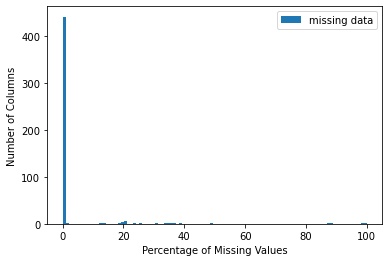

In [7]:
# 2019 Investigate patterns in the amount of missing data in each column.

percent_naturalmissing_per_column =(listing2019_df.isnull().sum()/len(listing2019_df))*100
bins = np.linspace(0, 100, 100)
plt.hist(percent_naturalmissing_per_column, bins, label='missing data')
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.legend(loc='upper right')
plt.show()


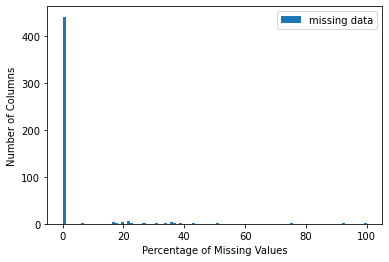

In [8]:
# 2020 Investigate patterns in the amount of missing data in each column.

percent_naturalmissing_per_column =(listing2020_df.isnull().sum()/len(listing2020_df))*100
bins = np.linspace(0, 100, 100)
plt.hist(percent_naturalmissing_per_column, bins, label='missing data')
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.legend(loc='upper right')
plt.show()


In [9]:
"""For consistency and simplicity sake we will eliminiate from both datasets any 
columns that have >20% missing values in either dataset"""
#Based on the above histograms, any column that has more than 20% data missing can be considered outlier and dropped
first_list=cleanedNan2019[cleanedNan2019['percent_missing']>20]['Attribute'].tolist()
second_list=cleanedNan2020[cleanedNan2020['percent_missing']>20]['Attribute'].tolist()
col_todrop=first_list + list(set(second_list) - set(first_list))
print(col_todrop)



['neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_about', 'host_response_time', 'host_response_rate', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'calendar_updated_since', 'first_review', 'reviews_per_month', 'last_review', 'cleaning_fee']


In [10]:
#drop the columns to create final dataset
listing2019_finaldf=listing2019_df.drop(col_todrop, axis = 1)
listing2020_finaldf=listing2020_df.drop(col_todrop, axis = 1)


In [11]:
# How much data is missing in each row of the dataset?

cleanedrowNan2019=pd.Series(listing2019_finaldf.isnull().sum(axis = 1),name='total_missing_Records').to_frame()
cleanedrowNan2019['percent_missing'] =(listing2019_finaldf.isnull().sum(axis = 1)/len(listing2019_finaldf.columns))*100
cleanedrowNan2019.head()

,total_missing_Records,percent_missing
0,0,0.000000
1,0,0.000000
2,1,0.224719
3,0,0.000000
4,0,0.000000


In [12]:
cleanedrowNan2020=pd.Series(listing2020_finaldf.isnull().sum(axis = 1),name='total_missing_Records').to_frame()
cleanedrowNan2020['percent_missing'] =(listing2020_finaldf.isnull().sum(axis = 1)/len(listing2020_finaldf.columns))*100
cleanedrowNan2020.head()


,total_missing_Records,percent_missing
0,3,0.674157
1,1,0.224719
2,2,0.449438
3,2,0.449438
4,2,0.449438


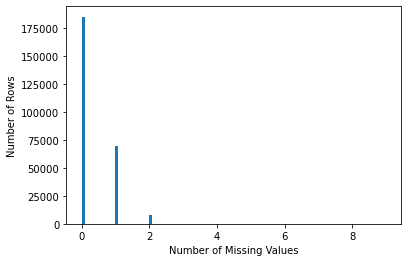

In [13]:
# How much data is missing in each row of the dataset?
missing_per_row =listing2019_finaldf.isnull().sum(axis=1)
plt.hist(missing_per_row, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()


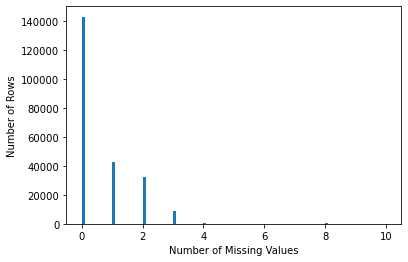

In [14]:
missing_per_row =listing2020_finaldf.isnull().sum(axis=1)
plt.hist(missing_per_row, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [15]:
"""For consistency and simplicity sake we will eliminiate from both datasets any 
rows that have >20% missing values in either dataset"""
#Based on the above histograms, any row that has more than 20% data missing can be considered outlier and dropped
listing2019_finaldf=listing2019_finaldf.loc[cleanedrowNan2019['percent_missing']<20,:]
listing2020_finaldf=listing2020_finaldf.loc[cleanedrowNan2020['percent_missing']<20,:]
print(listing2019_finaldf.shape)
print(listing2020_finaldf.shape)

(261925, 445)
(227351, 445)


In [16]:
listing2019_finaldf.head()

Attribute,id,host_since,host_location,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,month_datascraped,calendar_updated_timeslab,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id,amenities_Dual_vanity,amenities_Room_service,amenities_Shampoo,amenities_Steam_oven,amenities_Lap_pool,amenities_Safety_card,amenities_Driveway_parking,amenities_Alfresco_shower,amenities_Wide_doorway_to_guest_bathroom,amenities_Flat_path_to_front_door,amenities_Accessible_height_bed,amenities_Smart_lock,amenities_Breakfast,amenities_Carbon_monoxide_detector,amenities_Mini_fridge,amenities_Terrace,amenities_Shared_gym,amenities_Building_staff,amenities_Buzzer_wireless_intercom,amenities_Sound_system,amenities_Outdoor_parking,amenities_Play_Room,amenities_Walk_in_closet,amenities_Hand_soap,amenities_Firm_mattress,amenities_Large_mirror,amenities_Dishwasher,amenities_Lounge_area,amenities_HBO_GO,amenities_Wide_entrance,amenities_Shower_gel,amenities_Step_free_access,amenities_Smoking_allowed,amenities_Dog_s_,amenities_DVD_player,amenities_Bed_linens,amenities_Piano,amenities_Essentials,amenities_Foosball_table,amenities_Pillow_top_mattress,amenities_Shower_bathtub_combo,amenities_Touchless_faucets,amenities_Espresso_machine,amenities_Fixed_grab_bars_for_shower,amenities_Paid_parking_on_premises,amenities_Soaking_tub,amenities_Indoor_fireplace,amenities_Basketball_court,amenities_Gazebo,amenities_Charcoal_barbeque,amenities_Gym,amenities_Lounge_chairs,amenities_Shared_pool,amenities_Ceiling_hoist,amenities_Wide_hallway_clearance,amenities_Wood_burning_fireplace,amenities_Swimming_pool,amenities_Cigar_room,amenities_Convection_oven,amenities_Laundry_services,amenities_Ceiling_fans,amenities_Minibar,amenities_Toaster,amenities_Wine_cooler,amenities_Pool,amenities_Covered_parking,amenities_Surfboard,amenities_Microwave,amenities_Carbon_monoxide_alarm,amenities_Game_table,amenities_Snorkeling_equipment,amenities_Self_parking,amenities_Surround_sound_system,amenities_Decorative_fireplace,amenities_Paid_parking_off_premises,amenities_Private_pool,amenities_Printer,amenities_Gated_community,amenities_Cleaning_before_checkout,amenities_Smart_Technology,amenities_Wide_clearance_to_shower,amenities_Bathroom_essentials,amenities_Wide_entrance_for_guests,amenities_Fixed_grab_bars_for_toilet,amenities_Flat_path_to_guest_entrance,amenities_Bathtub,amenities_Bedroom_comforts,amenities_Heated_infinity_pool,amenities_Family_kid_friendly,amenities_Day_bed,amenities_Window_guards,amenities_Patio,amenities_Brick_oven,amenities_Dryer,amenities_Private_gym,amenities_Bicycle,amenities_TV,amenities_Internet,amenities_Barbecue_utensils,amenities_Body_soap,amenities_Handheld_shower_head,amenities_Stand_alone_shower,amenities_Computer,amenities_Desk,amenities_Children_s_toys,amenitie

In [17]:
#looking at object variables
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listing2019_finaldf[listing2019_finaldf.select_dtypes(include=['object']).columns.tolist()].head(2)

Attribute,host_location,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,is_location_exact,property_type,room_type,bed_type,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,month_datascraped,calendar_updated_timeslab,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id,amenities_Dual_vanity,amenities_Room_service,amenities_Shampoo,amenities_Steam_oven,amenities_Lap_pool,amenities_Safety_card,amenities_Driveway_parking,amenities_Alfresco_shower,amenities_Wide_doorway_to_guest_bathroom,amenities_Flat_path_to_front_door,amenities_Accessible_height_bed,amenities_Smart_lock,amenities_Breakfast,amenities_Carbon_monoxide_detector,amenities_Mini_fridge,amenities_Terrace,amenities_Shared_gym,amenities_Building_staff,amenities_Buzzer_wireless_intercom,amenities_Sound_system,amenities_Outdoor_parking,amenities_Play_Room,amenities_Walk_in_closet,amenities_Hand_soap,amenities_Firm_mattress,amenities_Large_mirror,amenities_Dishwasher,amenities_Lounge_area,amenities_HBO_GO,amenities_Wide_entrance,amenities_Shower_gel,amenities_Step_free_access,amenities_Smoking_allowed,amenities_Dog_s_,amenities_DVD_player,amenities_Bed_linens,amenities_Piano,amenities_Essentials,amenities_Foosball_table,amenities_Pillow_top_mattress,amenities_Shower_bathtub_combo,amenities_Touchless_faucets,amenities_Espresso_machine,amenities_Fixed_grab_bars_for_shower,amenities_Paid_parking_on_premises,amenities_Soaking_tub,amenities_Indoor_fireplace,amenities_Basketball_court,amenities_Gazebo,amenities_Charcoal_barbeque,amenities_Gym,amenities_Lounge_chairs,amenities_Shared_pool,amenities_Ceiling_hoist,amenities_Wide_hallway_clearance,amenities_Wood_burning_fireplace,amenities_Swimming_pool,amenities_Cigar_room,amenities_Convection_oven,amenities_Laundry_services,amenities_Ceiling_fans,amenities_Minibar,amenities_Toaster,amenities_Wine_cooler,amenities_Pool,amenities_Covered_parking,amenities_Surfboard,amenities_Microwave,amenities_Carbon_monoxide_alarm,amenities_Game_table,amenities_Snorkeling_equipment,amenities_Self_parking,amenities_Surround_sound_system,amenities_Decorative_fireplace,amenities_Paid_parking_off_premises,amenities_Private_pool,amenities_Printer,amenities_Gated_community,amenities_Cleaning_before_checkout,amenities_Smart_Technology,amenities_Wide_clearance_to_shower,amenities_Bathroom_essentials,amenities_Wide_entrance_for_guests,amenities_Fixed_grab_bars_for_toilet,amenities_Flat_path_to_guest_entrance,amenities_Bathtub,amenities_Bedroom_comforts,amenities_Heated_infinity_pool,amenities_Family_kid_friendly,amenities_Day_bed,amenities_Window_guards,amenities_Patio,amenities_Brick_oven,amenities_Dryer,amenities_Private_gym,amenities_Bicycle,amenities_TV,amenities_Internet,amenities_Barbecue_utensils,amenities_Body_soap,amenities_Handheld_shower_head,amenities_Stand_alone_shower,amenities_Computer,amenities_Desk,amenities_Children_s_toys,amenities_Standing_valet,amenities_Suitable_for_events,amenities_Smart_home_technology,amenities_Satellite_TV,amenities_Hand_or_paper_towel,amenities_Coffee_maker,amenities_Extra_pillows_and_blankets,amenities_Sun_deck,amenities_Wide_entryway,amenities_Formal_dining_area,amenities_Heating,amenities_Putting_green,amenities_Cable_TV,amenities_Jetted_tub,amenities_Patio_or_balcony,amenities_Doorman,amenities_Spa,amenities_Shuffleboard,amenities_Bread_maker,amenities_Outdoor_kitchen,amenities_First_aid_kit,amenities_Hot_tub,amenities_Breakfast_table,amenities_Restaurant,amenities_Gas_fireplace,amenities_Baby_equipm

In [18]:
#recheck memory usage
listing2019_finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261925 entries, 0 to 261924
Columns: 445 entries, id to amenities_Laptop_friendly_workspace_comb
dtypes: float64(12), int64(20), object(413)
memory usage: 891.3+ MB


### 2.4 Data imputation and dummy coding

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#looking at only categorical attributes
cat_features = listing2020_finaldf.select_dtypes(include=['object']).columns.tolist()

#seperate binary and multi level feature
binary_feature = []
multi_feature=[]
for feature in cat_features:
    #checking for 3 in Binary encoding to accomodate for Null values
    if (len(listing2020_finaldf[feature].unique())<=3):
        binary_feature.append(feature)
    elif (len(listing2020_finaldf[feature].unique())>3):
        multi_feature.append(feature)
        
print("Categorical attributes with Binary features: {}".format(len(binary_feature)))

print("Categorical attributes with Multi level features: {}".format(len(multi_feature)))


Categorical attributes with Binary features: 399
Categorical attributes with Multi level features: 14


In [23]:
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, listing2020_finaldf[feature].unique()))

Unique values for host_is_superhost are ['f' 't' None]
Unique values for host_has_profile_pic are ['t' 'f' None]
Unique values for host_identity_verified are ['f' 't' None]
Unique values for neighbourhood_group_cleansed are ['Other Cities' 'City of Los Angeles' 'Unincorporated Areas']
Unique values for is_location_exact are ['f' 't']
Unique values for requires_license are ['f' 't']
Unique values for instant_bookable are ['f' 't']
Unique values for require_guest_profile_picture are ['f' 't']
Unique values for require_guest_phone_verification are ['f' 't']
Unique values for hostver_manual_offline are ['f' 't']
Unique values for hostver_photographer are ['f' 't']
Unique values for hostver_zhima_selfie are ['f' 't']
Unique values for hostver_weibo are ['f' 't']
Unique values for hostver_kba are ['f' 't']
Unique values for hostver_email are ['t' 'f']
Unique values for hostver_reviews are ['t' 'f']
Unique values for hostver_sesame are ['f' 't']
Unique values for hostver_identity_manual are [

In [24]:
#add neighbourhood_group_cleansed to multi-feature since it has 3 unique  
binary_feature.remove('neighbourhood_group_cleansed')
multi_feature.append('neighbourhood_group_cleansed')

for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, listing2020_finaldf[feature].unique()))

Unique values for host_is_superhost are ['f' 't' None]
Unique values for host_has_profile_pic are ['t' 'f' None]
Unique values for host_identity_verified are ['f' 't' None]
Unique values for is_location_exact are ['f' 't']
Unique values for requires_license are ['f' 't']
Unique values for instant_bookable are ['f' 't']
Unique values for require_guest_profile_picture are ['f' 't']
Unique values for require_guest_phone_verification are ['f' 't']
Unique values for hostver_manual_offline are ['f' 't']
Unique values for hostver_photographer are ['f' 't']
Unique values for hostver_zhima_selfie are ['f' 't']
Unique values for hostver_weibo are ['f' 't']
Unique values for hostver_kba are ['f' 't']
Unique values for hostver_email are ['t' 'f']
Unique values for hostver_reviews are ['t' 'f']
Unique values for hostver_sesame are ['f' 't']
Unique values for hostver_identity_manual are ['f' 't']
Unique values for hostver_work_email are ['t' 'f']
Unique values for hostver_jumio are ['f' 't']
Unique 

In [25]:
# Re-encode Binary categorical variable(s) to be kept in the analysis.
new_values = {'f': 0, 't': 1}
for feature in binary_feature:
    listing2020_finaldf = listing2020_finaldf.replace({feature:new_values})
    listing2019_finaldf = listing2019_finaldf.replace({feature:new_values})
    
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, listing2020_finaldf[feature].unique()))

Unique values for host_is_superhost are [ 0.  1. nan]
Unique values for host_has_profile_pic are [ 1.  0. nan]
Unique values for host_identity_verified are [ 0.  1. nan]
Unique values for is_location_exact are [0 1]
Unique values for requires_license are [0 1]
Unique values for instant_bookable are [0 1]
Unique values for require_guest_profile_picture are [0 1]
Unique values for require_guest_phone_verification are [0 1]
Unique values for hostver_manual_offline are [0 1]
Unique values for hostver_photographer are [0 1]
Unique values for hostver_zhima_selfie are [0 1]
Unique values for hostver_weibo are [0 1]
Unique values for hostver_kba are [0 1]
Unique values for hostver_email are [1 0]
Unique values for hostver_reviews are [1 0]
Unique values for hostver_sesame are [0 1]
Unique values for hostver_identity_manual are [0 1]
Unique values for hostver_work_email are [1 0]
Unique values for hostver_jumio are [0 1]
Unique values for hostver_facebook are [0 1]
Unique values for hostver_ses

In [20]:
#looking at object variables
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listing2019_finaldf[listing2019_finaldf.select_dtypes(include=['object']).columns.tolist()].head(2)

,host_location,host_neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,property_type,room_type,bed_type,cancellation_policy,month_datascraped,calendar_updated_timeslab
0,"San Francisco, California, United States",Potrero Hill,Glendale,Other Cities,Glendale,CA,None,Los Angeles,"Glendale, CA",Apartment,Entire home/apt,Real Bed,strict,Jan2019,week
1,"San Francisco, California, United States",Potrero Hill,Glendale,Other Cities,Glendale,CA,None,Los Angeles,"Glendale, CA",Apartment,Entire home/apt,Real Bed,strict,Jan2019,week


In [23]:
for feature in multi_feature:
    print('Unique values for {} are {},count {}'.format(feature, listing2020_finaldf[feature].unique(),len(listing2020_finaldf[feature].unique())))

Unique values for host_location are ['Manhattan Beach, California, United States'
 'Los Angeles, California, United States'
 'Culver City, California, United States' ...
 'Banning, California, United States' 'Edmonton, Alberta, Canada'
 'Columbus, Georgia, United States'],count 1088
Unique values for host_neighbourhood are [None 'Culver City' 'Reseda' 'San Gabriel' 'Westwood' 'Mid-City'
 'Mid-Wilshire' 'Central LA' 'Westlake' 'West Adams' 'South LA'
 'Baldwin Hills' 'Downtown' 'Little Havana' 'Arts District'
 'Downtown Los Angeles' 'Laurel Canyon' 'Echo Park' 'Skid Row' 'Hollywood'
 'Mid City' 'Redondo Beach' 'West Hollywood' 'Bay Ridge' 'Williamsburg'
 'East Los Angeles' 'West Los Angeles' 'Silver Lake' 'Venice' 'Topanga'
 'Del Rey' 'Park West' 'Pacific Palisades' 'Beverly Hills'
 'Rancho Palos Verdes' 'West Covina' 'Pasadena' 'Alhambra' 'San Pedro'
 'Woodland Hills/Warner Center' 'El Sereno' 'Long Beach' 'Inglewood'
 'Old Town Torrance' 'Brentwood' 'Sherman Oaks' 'Santa Monica'
 'Her

**Using Binary encoding for Multi value features since we dont want to create too many variables 
Binary encoding is useful in high dimentionality cases , however not very intuitive to interpret, therefor we will keep a copy of the original vs transformed features for interpretation later**


In [24]:
#Binary encode Multi value features in 2019 dataset
encoder= ce.BinaryEncoder(cols=multi_feature)
dfbin=encoder.fit_transform(listing2019_finaldf.loc[:,multi_feature])
#make a copy of original feature and transformed 
bin_decode2019=pd.concat([listing2019_finaldf.loc[:,multi_feature],dfbin],axis=1)
bin_decode2019.drop_duplicates(keep=False,inplace=True) 

#Add transformed features to listing dataset and drop original features
listing2019_finaldf=pd.concat([listing2019_finaldf,dfbin],axis=1)
#retain month_datascraped in final dataset since we need it to join to calendar dataset
multi_feature.remove('month_datascraped')
listing2019_finaldf=listing2019_finaldf.drop(multi_feature,axis=1)
listing2019_finaldf.head()

,id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,month_datascraped,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id,amenities_Dual_vanity,amenities_Room_service,amenities_Shampoo,amenities_Steam_oven,amenities_Lap_pool,amenities_Safety_card,amenities_Driveway_parking,amenities_Alfresco_shower,amenities_Wide_doorway_to_guest_bathroom,amenities_Flat_path_to_front_door,amenities_Accessible_height_bed,amenities_Smart_lock,amenities_Breakfast,amenities_Carbon_monoxide_detector,amenities_Mini_fridge,amenities_Terrace,amenities_Shared_gym,amenities_Building_staff,amenities_Buzzer_wireless_intercom,amenities_Sound_system,amenities_Outdoor_parking,amenities_Play_Room,amenities_Walk_in_closet,amenities_Hand_soap,amenities_Firm_mattress,amenities_Large_mirror,amenities_Dishwasher,amenities_Lounge_area,amenities_HBO_GO,amenities_Wide_entrance,amenities_Shower_gel,amenities_Step_free_access,amenities_Smoking_allowed,amenities_Dog_s_,amenities_DVD_player,amenities_Bed_linens,amenities_Piano,amenities_Essentials,amenities_Foosball_table,amenities_Pillow_top_mattress,amenities_Shower_bathtub_combo,amenities_Touchless_faucets,amenities_Espresso_machine,amenities_Fixed_grab_bars_for_shower,amenities_Paid_parking_on_premises,amenities_Soaking_tub,amenities_Indoor_fireplace,amenities_Basketball_court,amenities_Gazebo,amenities_Charcoal_barbeque,amenities_Gym,amenities_Lounge_chairs,amenities_Shared_pool,amenities_Ceiling_hoist,amenities_Wide_hallway_clearance,amenities_Wood_burning_fireplace,amenities_Swimming_pool,amenities_Cigar_room,amenities_Convection_oven,amenities_Laundry_services,amenities_Ceiling_fans,amenities_Minibar,amenities_Toaster,amenities_Wine_cooler,amenities_Pool,amenities_Covered_parking,amenities_Surfboard,amenities_Microwave,amenities_Carbon_monoxide_alarm,amenities_Game_table,amenities_Snorkeling_equipment,amenities_Self_parking,amenities_Surround_sound_system,amenities_Decorative_fireplace,amenities_Paid_parking_off_premises,amenities_Private_pool,amenities_Printer,amenities_Gated_community,amenities_Cleaning_before_checkout,amenities_Smart_Technology,amenities_Wide_clearance_to_shower,amenities_Bathroom_essentials,amenities_Wide_entrance_for_guests,amenities_Fixed_grab_bars_for_toilet,amenities_Flat_path_to_guest_entrance,amenities_Bathtub,amenities_Bedroom_comforts,amenities_Heated_infinity_pool,amenities_Family_kid_friendly,amenities_Day_bed,amenities_Window_guards,amenities_Patio,amenities_Brick_oven,amenities_Dryer,amenities_Private_gym,amenities_Bicycle,amenities_TV,amenities_Internet,amenities_Barbecue_utensils,amenities_Body_soap,amenities_Handheld_shower_head,amenities_Stand_alone_shower,amenities_Computer,amenities_Desk,amenities_Children_s_toys,amenities_Standing_valet,amenities_Suitable_for_events,amenities_Smart_home_technology,amenities_Satellite_TV,amenities_Hand_or_paper_towel,amenities_Coffee_maker,amenities_Extra_pillows_and_blankets,amenities_Sun_deck,ame

In [25]:
#Binary encode Multi value features in 2020 dataset
multi_feature.append('month_datascraped')
dfbin=encoder.fit_transform(listing2020_finaldf.loc[:,multi_feature])
#make a copy of original feature and transformed 
bin_decode2020=pd.concat([listing2020_finaldf.loc[:,multi_feature],dfbin],axis=1)
bin_decode2020.drop_duplicates(keep=False,inplace=True) 

#Add transformed features to listing dataset and drop original features
listing2020_finaldf=pd.concat([listing2020_finaldf,dfbin],axis=1)
multi_feature.remove('month_datascraped')
listing2020_finaldf=listing2020_finaldf.drop(multi_feature,axis=1)
listing2020_finaldf.head()

,id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,month_datascraped,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id,amenities_Dual_vanity,amenities_Room_service,amenities_Shampoo,amenities_Steam_oven,amenities_Lap_pool,amenities_Safety_card,amenities_Driveway_parking,amenities_Alfresco_shower,amenities_Wide_doorway_to_guest_bathroom,amenities_Flat_path_to_front_door,amenities_Accessible_height_bed,amenities_Smart_lock,amenities_Breakfast,amenities_Carbon_monoxide_detector,amenities_Mini_fridge,amenities_Terrace,amenities_Shared_gym,amenities_Building_staff,amenities_Buzzer_wireless_intercom,amenities_Sound_system,amenities_Outdoor_parking,amenities_Play_Room,amenities_Walk_in_closet,amenities_Hand_soap,amenities_Firm_mattress,amenities_Large_mirror,amenities_Dishwasher,amenities_Lounge_area,amenities_HBO_GO,amenities_Wide_entrance,amenities_Shower_gel,amenities_Step_free_access,amenities_Smoking_allowed,amenities_Dog_s_,amenities_DVD_player,amenities_Bed_linens,amenities_Piano,amenities_Essentials,amenities_Foosball_table,amenities_Pillow_top_mattress,amenities_Shower_bathtub_combo,amenities_Touchless_faucets,amenities_Espresso_machine,amenities_Fixed_grab_bars_for_shower,amenities_Paid_parking_on_premises,amenities_Soaking_tub,amenities_Indoor_fireplace,amenities_Basketball_court,amenities_Gazebo,amenities_Charcoal_barbeque,amenities_Gym,amenities_Lounge_chairs,amenities_Shared_pool,amenities_Ceiling_hoist,amenities_Wide_hallway_clearance,amenities_Wood_burning_fireplace,amenities_Swimming_pool,amenities_Cigar_room,amenities_Convection_oven,amenities_Laundry_services,amenities_Ceiling_fans,amenities_Minibar,amenities_Toaster,amenities_Wine_cooler,amenities_Pool,amenities_Covered_parking,amenities_Surfboard,amenities_Microwave,amenities_Carbon_monoxide_alarm,amenities_Game_table,amenities_Snorkeling_equipment,amenities_Self_parking,amenities_Surround_sound_system,amenities_Decorative_fireplace,amenities_Paid_parking_off_premises,amenities_Private_pool,amenities_Printer,amenities_Gated_community,amenities_Cleaning_before_checkout,amenities_Smart_Technology,amenities_Wide_clearance_to_shower,amenities_Bathroom_essentials,amenities_Wide_entrance_for_guests,amenities_Fixed_grab_bars_for_toilet,amenities_Flat_path_to_guest_entrance,amenities_Bathtub,amenities_Bedroom_comforts,amenities_Heated_infinity_pool,amenities_Family_kid_friendly,amenities_Day_bed,amenities_Window_guards,amenities_Patio,amenities_Brick_oven,amenities_Dryer,amenities_Private_gym,amenities_Bicycle,amenities_TV,amenities_Internet,amenities_Barbecue_utensils,amenities_Body_soap,amenities_Handheld_shower_head,amenities_Stand_alone_shower,amenities_Computer,amenities_Desk,amenities_Children_s_toys,amenities_Standing_valet,amenities_Suitable_for_events,amenities_Smart_home_technology,amenities_Satellite_TV,amenities_Hand_or_paper_towel,amenities_Coffee_maker,amenities_Extra_pillows_and_blankets,amenities_Sun_deck,ame

**DATACHECKPOINT- Upload final listing and binary decode datasets to BigQuery for analysis**

In [28]:
pandas_gbq.to_gbq(listing2019_finaldf, 'airbnbLA.listing2019df', project_id='udacity-crisp-dm-project',if_exists='fail')
pandas_gbq.to_gbq(listing2020_finaldf, 'airbnbLA.listing2020df', project_id='udacity-crisp-dm-project',if_exists='fail')

1it [02:26, 146.11s/it]
1it [02:20, 140.08s/it]


In [29]:
pandas_gbq.to_gbq(bin_decode2019, 'airbnbLA.bin_decode2019', project_id='udacity-crisp-dm-project',if_exists='fail')
pandas_gbq.to_gbq(bin_decode2020, 'airbnbLA.bin_decode2020', project_id='udacity-crisp-dm-project',if_exists='fail')


1it [00:26, 26.44s/it]
1it [00:35, 35.28s/it]


#### Run queries on Bigquery platform to save processing time 

- Querys to join the final listings dataset with the pivoted calendar dataset(created in Part-1), the results were saved in listing2019_FINAL and listing2020_FINAL tables 

<blockquote>
select a.*,b.year,b.month,b.day_of_week, future_bookings, Avgprice
from udacity-crisp-dm-project.airbnbLA.listing2019df A
INNER join udacity-crisp-dm-project.airbnbLA.bookedlisting_2019 B
on CAST(A.id AS STRING)=B.listing_id and A.month_datascraped=B.month_datascraped
</blockquote>    

<blockquote>
select a.*,b.year,b.month,b.day_of_week, future_bookings, Avgprice
from udacity-crisp-dm-project.airbnbLA.listing2020df A
INNER join udacity-crisp-dm-project.airbnbLA.bookedlisting_2020 B
on CAST(A.id AS STRING)=B.listing_id and A.month_datascraped=B.month_datascraped
</blockquote>


### 2.5 Machine Learning
#### Building a Random Forest Model to identify most important features

**Read dataset for ML training**
The overall dataset is too large for running ML models on this platform, we will subset to only the bookings in the months of March-June for building the ML model. I have chosen these months since lockdown was announced in the month of Feb in Los Angeles and it would be the most impactful in this analysis


In [3]:
# Importing 2019 dataset from BigQuery

#Partition data reading by month to save memory and processing time

list_2019 = {}
for month in range(3,7,1):
    print("2019 fetching month: "+str(month))
    sql = str("""
        SELECT *
        FROM udacity-crisp-dm-project.airbnbLA.listing2019_Final
        WHERE month={}
    """).format(month)

    temp_df = pd.read_gbq(sql, use_bqstorage_api=True)
    temp_df=reduce_mem_usage(temp_df)
    list_2019[month]=temp_df
       

2019 fetching month: 3


Downloading: 100%|██████████| 197093/197093 [00:43<00:00, 4565.91rows/s]


Memory usage of dataframe is 812.00 MB
Memory usage after optimization is: 109.02 MB
Decreased by 86.6%
2019 fetching month: 4


Downloading: 100%|██████████| 194884/194884 [00:44<00:00, 4428.03rows/s]


Memory usage of dataframe is 802.90 MB
Memory usage after optimization is: 107.80 MB
Decreased by 86.6%
2019 fetching month: 5


Downloading: 100%|██████████| 196085/196085 [00:44<00:00, 4442.56rows/s]


Memory usage of dataframe is 807.85 MB
Memory usage after optimization is: 108.46 MB
Decreased by 86.6%
2019 fetching month: 6


Downloading: 100%|██████████| 197537/197537 [00:43<00:00, 4564.33rows/s]


Memory usage of dataframe is 813.83 MB
Memory usage after optimization is: 109.26 MB
Decreased by 86.6%


In [4]:
#Concat the list dataframes into one single Pandas dataframes 
listing2019_finaldf=pd.concat(list_2019)
listing2019_finaldf.head()

id  host_since  host_is_superhost  host_listings_count  \
3 0  24496605      1318.0                0.0                 20.0   
  1  24577654       924.0                1.0                  2.0   
  2  30399402       797.0                0.0                  1.0   
  3  16304936      1366.0                0.0                  2.0   
  4   4341543      2784.0                0.0                  2.0   

     host_total_listings_count  host_has_profile_pic  host_identity_verified  \
3 0                       20.0                   1.0                     1.0   
  1                        2.0                   1.0                     0.0   
  2                        1.0                   1.0                     0.0   
  3                        2.0                   1.0                     1.0   
  4                        2.0                   1.0                     1.0   

     latitude  longitude  is_location_exact  ...  month_datascraped_2  \
3 0  34.09375  -118.3125                  0  ...                    1   
  1  34.00000  -117.8750                  1  ...                    1   
  2  34.06250  -118.3125                  0  ...                    1   
  3  34.09375  -118.3750                  1  ...                    1   
  4  34.00000  -118.5000                  1  ...                    1   

     month_datascraped_3  calendar_updated_timeslab_0  \
3 0                    0                            0   
  1                    0                            0   
  2                    0                            0   
  3                    0                            0   
  4                    0                            0   

     calendar_updated_timeslab_1  calendar_updated_timeslab_2  \
3 0                            0                            0   
  1                            0                            0   
  2                            1                            0   
  3                            0                            1   
  4                            0                            0   

     calendar_updated_timeslab_3  year  month  future_bookings  Avgprice  
3 0                            1  2020      3               31   86.4375  
  1                            0  2020      3               31   32.0000  
  2                            1  2020      3               31   88.0000  
  3                            0  2020      3               31   99.0000  
  4                            1  2020      3               31  159.0000  

[5 rows x 540 columns]

In [5]:
#checking memory size of dataframe
listing2019_finaldf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 785599 entries, (3, 0) to (6, 197536)
Columns: 540 entries, id to Avgprice
dtypes: category(1), float16(15), float32(1), int16(10), int32(4), int8(509)
memory usage: 439.8 MB


In [6]:
#Delete redundant variables  to free memory
del list_2019
del temp_df
gc.collect()

#reset index
listing2019_finaldf=listing2019_finaldf.reset_index(drop=True)
listing2019_finaldf.shape

(785599, 540)

**Few additional Multi value features were added after joining with the Calendar dataset and it would need additional Dummy coding and imputation**

In [7]:
#relooking at remaining multi features
cat_features = listing2019_finaldf.select_dtypes(include=['object','category']).columns.tolist()

multi_feature=[]
for feature in cat_features:
    if len(listing2019_finaldf[feature].unique())>=2:
        multi_feature.append(feature)

for feature in multi_feature:
    print('Unique values for {} are {},count {}'.format(feature, listing2019_finaldf[feature].unique(),len(listing2019_finaldf[feature].unique())))

Unique values for month_datascraped are [April2019, March2019, Feb2019, Jan2019, June2019, May2019]
Categories (6, object): [April2019, March2019, Feb2019, Jan2019, June2019, May2019],count 6


In [8]:
# Dummy encode year and month variables (month has already been encoded and will be dropped)
listing2019_finaldf=pd.get_dummies(listing2019_finaldf,columns=['year','month'])
listing2019_finaldf.head()

,id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,...,calendar_updated_timeslab_2,calendar_updated_timeslab_3,future_bookings,Avgprice,year_2019,year_2020,month_3,month_4,month_5,month_6
0,24496605,1318.0,0.0,20.0,20.0,1.0,1.0,34.09375,-118.3125,0,...,0,1,31,86.4375,0,1,1,0,0,0
1,24577654,924.0,1.0,2.0,2.0,1.0,0.0,34.00000,-117.8750,1,...,0,0,31,32.0000,0,1,1,0,0,0
2,30399402,797.0,0.0,1.0,1.0,1.0,0.0,34.06250,-118.3125,0,...,0,1,31,88.0000,0,1,1,0,0,0
3,16304936,1366.0,0.0,2.0,2.0,1.0,1.0,34.09375,-118.3750,1,...,1,0,31,99.0000,0,1,1,0,0,0
4,4341543,2784.0,0.0,2.0,2.0,1.0,1.0,34.00000,-118.5000,1,...,0,1,31,159.0000,0,1,1,0,0,0


In [9]:
#drop month_Datascraped,id variable since they were just being withheld for table joining
listing2019_finaldf=listing2019_finaldf.drop(['month_datascraped','id'],axis=1)

In [10]:
#total rowcount
listing2019_finaldf.shape

(785599, 542)

In [13]:
#Null values in dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listing2019_finaldf.isna().sum()

host_since                                              173
host_is_superhost                                       173
host_listings_count                                     173
host_total_listings_count                               173
host_has_profile_pic                                    173
host_identity_verified                                  173
latitude                                                  0
longitude                                                 0
is_location_exact                                         0
accommodates                                              0
bathrooms                                               226
bedrooms                                                369
beds                                                    522
price                                                     0
guests_included                                           0
extra_people                                              0
minimum_nights                          

In [14]:
pd.set_option('float_format', '{:f}'.format)
listing2019_finaldf.describe()

,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id,amenities_Dual_vanity,amenities_Room_service,amenities_Shampoo,amenities_Steam_oven,amenities_Lap_pool,amenities_Safety_card,amenities_Driveway_parking,amenities_Alfresco_shower,amenities_Wide_doorway_to_guest_bathroom,amenities_Flat_path_to_front_door,amenities_Accessible_height_bed,amenities_Smart_lock,amenities_Breakfast,amenities_Carbon_monoxide_detector,amenities_Mini_fridge,amenities_Terrace,amenities_Shared_gym,amenities_Building_staff,amenities_Buzzer_wireless_intercom,amenities_Sound_system,amenities_Outdoor_parking,amenities_Play_Room,amenities_Walk_in_closet,amenities_Hand_soap,amenities_Firm_mattress,amenities_Large_mirror,amenities_Dishwasher,amenities_Lounge_area,amenities_HBO_GO,amenities_Wide_entrance,amenities_Shower_gel,amenities_Step_free_access,amenities_Smoking_allowed,amenities_Dog_s_,amenities_DVD_player,amenities_Bed_linens,amenities_Piano,amenities_Essentials,amenities_Foosball_table,amenities_Pillow_top_mattress,amenities_Shower_bathtub_combo,amenities_Touchless_faucets,amenities_Espresso_machine,amenities_Fixed_grab_bars_for_shower,amenities_Paid_parking_on_premises,amenities_Soaking_tub,amenities_Indoor_fireplace,amenities_Basketball_court,amenities_Gazebo,amenities_Charcoal_barbeque,amenities_Gym,amenities_Lounge_chairs,amenities_Shared_pool,amenities_Ceiling_hoist,amenities_Wide_hallway_clearance,amenities_Wood_burning_fireplace,amenities_Swimming_pool,amenities_Cigar_room,amenities_Convection_oven,amenities_Laundry_services,amenities_Ceiling_fans,amenities_Minibar,amenities_Toaster,amenities_Wine_cooler,amenities_Pool,amenities_Covered_parking,amenities_Surfboard,amenities_Microwave,amenities_Carbon_monoxide_alarm,amenities_Game_table,amenities_Snorkeling_equipment,amenities_Self_parking,amenities_Surround_sound_system,amenities_Decorative_fireplace,amenities_Paid_parking_off_premises,amenities_Private_pool,amenities_Printer,amenities_Gated_community,amenities_Cleaning_before_checkout,amenities_Smart_Technology,amenities_Wide_clearance_to_shower,amenities_Bathroom_essentials,amenities_Wide_entrance_for_guests,amenities_Fixed_grab_bars_for_toilet,amenities_Flat_path_to_guest_entrance,amenities_Bathtub,amenities_Bedroom_comforts,amenities_Heated_infinity_pool,amenities_Family_kid_friendly,amenities_Day_bed,amenities_Window_guards,amenities_Patio,amenities_Brick_oven,amenities_Dryer,amenities_Private_gym,amenities_Bicycle,amenities_TV,amenities_Internet,amenities_Barbecue_utensils,amenities_Body_soap,amenities_Handheld_shower_head,amenities_Stand_alone_shower,amenities_Computer,amenities_Desk,amenities_Children_s_toys,amenities_Standing_valet,amenities_Suitable_for_events,amenities_Smart_home_technology,amenities_Satellite_TV,amenities_Hand_or_paper_towel,amenities_Coffee_maker,amenities_Extra_pillows_and_blankets,amenities_Sun_deck,amenities_Wide_entryway,

No major anomalies can be noticed from the spread of values above.

In [63]:
#Impute the Null values with the frequently occuring ones
model = SimpleImputer(strategy="most_frequent")
result = pd.DataFrame(model.fit_transform(listing2019_finaldf))
result.columns=listing2019_finaldf.columns
result.head()

,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id,amenities_Dual_vanity,amenities_Room_service,amenities_Shampoo,amenities_Steam_oven,amenities_Lap_pool,amenities_Safety_card,amenities_Driveway_parking,amenities_Alfresco_shower,amenities_Wide_doorway_to_guest_bathroom,amenities_Flat_path_to_front_door,amenities_Accessible_height_bed,amenities_Smart_lock,amenities_Breakfast,amenities_Carbon_monoxide_detector,amenities_Mini_fridge,amenities_Terrace,amenities_Shared_gym,amenities_Building_staff,amenities_Buzzer_wireless_intercom,amenities_Sound_system,amenities_Outdoor_parking,amenities_Play_Room,amenities_Walk_in_closet,amenities_Hand_soap,amenities_Firm_mattress,amenities_Large_mirror,amenities_Dishwasher,amenities_Lounge_area,amenities_HBO_GO,amenities_Wide_entrance,amenities_Shower_gel,amenities_Step_free_access,amenities_Smoking_allowed,amenities_Dog_s_,amenities_DVD_player,amenities_Bed_linens,amenities_Piano,amenities_Essentials,amenities_Foosball_table,amenities_Pillow_top_mattress,amenities_Shower_bathtub_combo,amenities_Touchless_faucets,amenities_Espresso_machine,amenities_Fixed_grab_bars_for_shower,amenities_Paid_parking_on_premises,amenities_Soaking_tub,amenities_Indoor_fireplace,amenities_Basketball_court,amenities_Gazebo,amenities_Charcoal_barbeque,amenities_Gym,amenities_Lounge_chairs,amenities_Shared_pool,amenities_Ceiling_hoist,amenities_Wide_hallway_clearance,amenities_Wood_burning_fireplace,amenities_Swimming_pool,amenities_Cigar_room,amenities_Convection_oven,amenities_Laundry_services,amenities_Ceiling_fans,amenities_Minibar,amenities_Toaster,amenities_Wine_cooler,amenities_Pool,amenities_Covered_parking,amenities_Surfboard,amenities_Microwave,amenities_Carbon_monoxide_alarm,amenities_Game_table,amenities_Snorkeling_equipment,amenities_Self_parking,amenities_Surround_sound_system,amenities_Decorative_fireplace,amenities_Paid_parking_off_premises,amenities_Private_pool,amenities_Printer,amenities_Gated_community,amenities_Cleaning_before_checkout,amenities_Smart_Technology,amenities_Wide_clearance_to_shower,amenities_Bathroom_essentials,amenities_Wide_entrance_for_guests,amenities_Fixed_grab_bars_for_toilet,amenities_Flat_path_to_guest_entrance,amenities_Bathtub,amenities_Bedroom_comforts,amenities_Heated_infinity_pool,amenities_Family_kid_friendly,amenities_Day_bed,amenities_Window_guards,amenities_Patio,amenities_Brick_oven,amenities_Dryer,amenities_Private_gym,amenities_Bicycle,amenities_TV,amenities_Internet,amenities_Barbecue_utensils,amenities_Body_soap,amenities_Handheld_shower_head,amenities_Stand_alone_shower,amenities_Computer,amenities_Desk,amenities_Children_s_toys,amenities_Standing_valet,amenities_Suitable_for_events,amenities_Smart_home_technology,amenities_Satellite_TV,amenities_Hand_or_paper_towel,amenities_Coffee_maker,amenities_Extra_pillows_and_blankets,amenities_Sun_deck,amenities_Wide_entryway,

In [16]:
#Check final Null values in dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sum(result.isna().sum())

0

**Seperating the dataset in Target and features**

In [12]:

# Labels are the values we want to predict
y = np.array(result['future_bookings'])
# Remove the labels from the features
# axis 1 refers to the columns
X= result.drop('future_bookings', axis = 1)
# Saving feature names for later use
feature_list = list(X.columns)

# Convert to numpy array
X = np.array(X)


**Note on Scaling**
Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.

Random Forest is a tree-based model and hence does not require feature scaling.

In [13]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [14]:
#Looking at the shape of the datasets
print('Training Features Shape: ', X_train.shape)
print('Training Target Shape: ',  Y_train.shape)
print('Testing Features Shape: ', X_test.shape)
print('Testing Target Shape: ', Y_test.shape)

Training Features Shape:  (589199, 541)
Training Target Shape:  (589199,)
Testing Features Shape:  (196400, 541)
Testing Target Shape:  (196400,)


#### Establish Baseline
Baseline is for our model to beat, if model cannot beat baseline we need to build a better model

**Random Forest Model on 2019 dataset**

In [19]:
# Look at parameters used in the default model
rf = RandomForestRegressor(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [15]:
#function to evaluate model performance
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} '.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

**2019 Base Model**

In [39]:
# Base model which we want to beat in performance
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42,n_jobs=-1,verbose=2)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_test, Y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   51.1s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


Model Performance
Average Error: 0.7520 
Accuracy = 87.81%.


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


**Grid Search** Next we will use a Grid search CV to find the optimal parameters for our model

In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 30, num = 3)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 70, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5,10]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(param_grid)

{'bootstrap': [True],
 'max_depth': [50, None],
 'max_features': ['auto'],
 'min_samples_leaf': [5, 10],
 'min_samples_split': [5, 10],
 'n_estimators': [20, 25, 30]}


In [26]:
#Gridsearch

rf = RandomForestRegressor(n_jobs=-2, random_state=42,verbose=2)
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 2,verbose=2)
CV_rfc.fit(X_train, Y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   46.8s remaining:  7.0min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   48.3s remaining:   26.0s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   47.0s remaining:  7.0min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   48.4s remaining:   26.1s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.1s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.9s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.9s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.3min remaining:   10.3s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   56.0s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total= 1.6min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   57.3s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.6min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total= 1.6min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   38.8s remaining:  5.8min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   49.3s remaining:   26.6s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total= 1.3min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   48.0s remaining:  7.2min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   49.1s remaining:   26.4s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total= 1.3min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.9s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:   10.1s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.7s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.3min remaining:   10.3s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.1min remaining:   51.8s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.3min remaining:   59.3s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total= 1.6min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   45.1s remaining:  6.8min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.4s remaining:   25.0s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   41.8s remaining:  6.3min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.6s remaining:   25.6s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.2s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.9s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   50.1s remaining:  1.5min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.3min remaining:   10.4s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   55.0s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.3min remaining:   57.6s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   45.3s remaining:  6.8min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.8s remaining:   25.2s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   45.9s remaining:  6.9min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.2s remaining:   25.4s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.3s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.8s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.4s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.7s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   55.7s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.3min remaining:   58.0s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   37.5s remaining:  5.6min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   48.1s remaining:   25.9s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   38.7s remaining:  5.8min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   48.5s remaining:   26.1s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20, total= 1.3min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.3s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.3min remaining:   10.3s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   48.6s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.3min remaining:   10.3s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   57.2s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   56.6s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.6min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total= 1.6min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   40.2s remaining:  6.0min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.8s remaining:   25.7s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   42.9s remaining:  6.4min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   48.6s remaining:   26.2s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total= 1.3min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.3s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:   10.0s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   48.8s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.3min remaining:   10.3s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   56.5s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total= 1.6min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   56.9s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total= 1.6min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   43.1s remaining:  6.5min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.7s remaining:   25.2s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   45.8s remaining:  6.9min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.7s remaining:   25.7s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.2s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.6s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.4s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.9s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   54.9s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.1min remaining:   51.2s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   33.0s remaining:  4.9min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.6s remaining:   25.1s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   36.5s remaining:  5.5min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.7s remaining:   25.2s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.4s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.9s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.0s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.8s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   55.6s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   55.7s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 66.8min finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30, total= 1.5min


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 15 concurrent workers.


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  2.0min remaining:  1.5min
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  2.2min finished


GridSearchCV(cv=2,
             estimator=RandomForestRegressor(n_jobs=-2, random_state=42,
                                             verbose=2),
             param_grid={'bootstrap': [True], 'max_depth': [50, None],
                         'max_features': ['auto'], 'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10],
                         'n_estimators': [20, 25, 30]},
             verbose=2)

In [27]:
CV_rfc.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 30}

In [28]:
# Evaluate performance of the best model according to Grid search
final2019_model = CV_rfc.best_estimator_#RandomForestRegressor(n_estimators = 350,min_samples_leaf= 50, min_samples_split= 100,random_state = 42,n_jobs=-1,verbose=2)
model2019_accuracy = evaluate(final2019_model, X_test, Y_test)

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


Model Performance
Average Error: 0.7229 
Accuracy = 88.13%.


**Clarification:** Although, not the best or most ideal performance we will go with this model since it managed to beat the base model.
Building a better model with such a large dataset within reasonable time would require additional computation infrastructure which was not available at the time of this analysis 

In [31]:
# save the model to disk
filename = 'listing2019final_model.sav'
pickle.dump(final2019_model, open(filename, 'wb'))

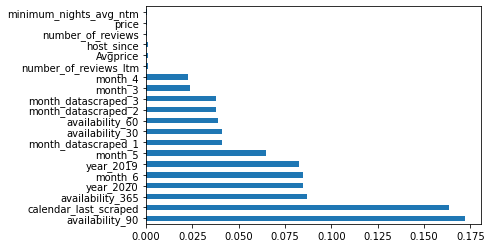

In [64]:
#Map Top 15 important features in this model
feat_importances = pd.Series(final2019_model.feature_importances_, index=result.drop('future_bookings', axis = 1).columns)
feat_importances.nlargest(20).plot(kind='barh')

In [61]:
# load the model from disk
filename = 'listing2019final_model.sav'
final2019_model= pickle.load(open(filename, 'rb'))

**Building the model for 2020 datatset**
Repeating all the above steps for 2020 dataset

In [33]:
# Importing 2019 dataset from BigQuery

#Partition data reading by month to save memory and processing time

list_2020 = {}
for month in range(3,7,1):
    print("2020 fetching month: "+str(month))
    sql = str("""
        SELECT *
        FROM udacity-crisp-dm-project.airbnbLA.listing2020_Final
        WHERE month={}
    """).format(month)

    temp_df = pd.read_gbq(sql, use_bqstorage_api=True)
    temp_df=reduce_mem_usage(temp_df)
    list_2020[month]=temp_df
       

2020 fetching month: 3


Downloading: 100%|██████████| 171973/171973 [00:39<00:00, 4312.75rows/s]


Memory usage of dataframe is 709.82 MB
Memory usage after optimization is: 96.27 MB
Decreased by 86.4%
2020 fetching month: 4


Downloading: 100%|██████████| 163575/163575 [00:38<00:00, 4296.28rows/s]


Memory usage of dataframe is 675.16 MB
Memory usage after optimization is: 91.57 MB
Decreased by 86.4%
2020 fetching month: 5


Downloading: 100%|██████████| 157861/157861 [00:37<00:00, 4254.13rows/s]


Memory usage of dataframe is 651.57 MB
Memory usage after optimization is: 88.37 MB
Decreased by 86.4%
2020 fetching month: 6


Downloading: 100%|██████████| 151549/151549 [00:35<00:00, 4257.73rows/s]


Memory usage of dataframe is 625.52 MB
Memory usage after optimization is: 84.84 MB
Decreased by 86.4%


In [34]:
#Concat the list dataframes into one single Pandas dataframes 
listing2020_finaldf=pd.concat(list_2020)
listing2020_finaldf.head()

id  host_since  host_is_superhost  host_listings_count  \
3 0   2764798     18512.0                0.0                  1.0   
  1  16351650     18512.0                0.0                  2.0   
  2   3475506     18512.0                0.0                  1.0   
  3  19658375     18512.0                0.0                  1.0   
  4  15884287     18512.0                0.0                  1.0   

     host_total_listings_count  host_has_profile_pic  host_identity_verified  \
3 0                        1.0                   1.0                     0.0   
  1                        2.0                   1.0                     0.0   
  2                        1.0                   1.0                     1.0   
  3                        1.0                   1.0                     0.0   
  4                        1.0                   1.0                     1.0   

     latitude  longitude  is_location_exact  ...  calendar_updated_timeslab_2  \
3 0  34.00000  -118.4375                  1  ...                            0   
  1  34.03125  -118.4375                  1  ...                            0   
  2  34.09375  -118.3125                  0  ...                            0   
  3  34.12500  -118.3125                  1  ...                            0   
  4  34.09375  -118.3125                  1  ...                            0   

     calendar_updated_timeslab_3  month_datascraped_0  month_datascraped_1  \
3 0                            1                    0                    1   
  1                            1                    0                    1   
  2                            1                    0                    1   
  3                            1                    0                    1   
  4                            1                    0                    1   

     month_datascraped_2  month_datascraped_3  year  month  future_bookings  \
3 0                    0                    0  2021      3               31   
  1                    0                    0  2021      3               31   
  2                    0                    0  2021      3               31   
  3                    0                    0  2021      3               31   
  4                    0                    0  2021      3               31   

     Avgprice  
3 0  500.0000  
  1  108.0000  
  2   65.0000  
  3  116.4375  
  4   80.3125  

[5 rows x 541 columns]

In [35]:
#checking memory size of dataframe
listing2020_finaldf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 644958 entries, (3, 0) to (6, 151548)
Columns: 541 entries, id to Avgprice
dtypes: category(1), float16(15), float32(1), int16(11), int32(1), int64(2), int8(510)
memory usage: 365.4 MB


In [36]:
#Delete redundant variables  to free memory
del list_2020
del temp_df
gc.collect()

#reset index
listing2020_finaldf=listing2020_finaldf.reset_index(drop=True)
listing2020_finaldf.shape

(644958, 541)

In [38]:
#relooking at remaining multi features
cat_features = listing2020_finaldf.select_dtypes(include=['object','category']).columns.tolist()

multi_feature=[]
for feature in cat_features:
    if len(listing2020_finaldf[feature].unique())>=2:
        multi_feature.append(feature)

for feature in multi_feature:
    print('Unique values for {} are {},count {}'.format(feature, listing2020_finaldf[feature].unique(),len(listing2020_finaldf[feature].unique())))

Unique values for month_datascraped are [May2020, June2020, April2020, March2020, Feb2020, Jan2020]
Categories (6, object): [May2020, June2020, April2020, March2020, Feb2020, Jan2020],count 6


In [39]:
# Dummy encode year and month variables (month has already been encoded and will be dropped)
listing2020_finaldf=pd.get_dummies(listing2020_finaldf,columns=['year','month'])
listing2020_finaldf.head()

,id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,...,month_datascraped_2,month_datascraped_3,future_bookings,Avgprice,year_2020,year_2021,month_3,month_4,month_5,month_6
0,2764798,18512.0,0.0,1.0,1.0,1.0,0.0,34.00000,-118.4375,1,...,0,0,31,500.0000,0,1,1,0,0,0
1,16351650,18512.0,0.0,2.0,2.0,1.0,0.0,34.03125,-118.4375,1,...,0,0,31,108.0000,0,1,1,0,0,0
2,3475506,18512.0,0.0,1.0,1.0,1.0,1.0,34.09375,-118.3125,0,...,0,0,31,65.0000,0,1,1,0,0,0
3,19658375,18512.0,0.0,1.0,1.0,1.0,0.0,34.12500,-118.3125,1,...,0,0,31,116.4375,0,1,1,0,0,0
4,15884287,18512.0,0.0,1.0,1.0,1.0,1.0,34.09375,-118.3125,1,...,0,0,31,80.3125,0,1,1,0,0,0


In [40]:
#drop month_Datascraped,id variable
listing2020_finaldf=listing2020_finaldf.drop(['month_datascraped','id'],axis=1)

In [41]:
#total rowcount
listing2020_finaldf.shape

(644958, 543)

In [42]:
#Null values in dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listing2020_finaldf.isna().sum()

host_since                                                 515
host_is_superhost                                          515
host_listings_count                                        515
host_total_listings_count                                  515
host_has_profile_pic                                       515
host_identity_verified                                     515
latitude                                                     0
longitude                                                    0
is_location_exact                                            0
accommodates                                                 0
bathrooms                                                  384
bedrooms                                                  1378
beds                                                      3945
price                                                   113989
guests_included                                              0
extra_people                                           

In [43]:
pd.set_option('float_format', '{:f}'.format)
listing2020_finaldf.describe()

,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id,amenities_Dual_vanity,amenities_Room_service,amenities_Shampoo,amenities_Steam_oven,amenities_Lap_pool,amenities_Safety_card,amenities_Driveway_parking,amenities_Alfresco_shower,amenities_Wide_doorway_to_guest_bathroom,amenities_Flat_path_to_front_door,amenities_Accessible_height_bed,amenities_Smart_lock,amenities_Breakfast,amenities_Carbon_monoxide_detector,amenities_Mini_fridge,amenities_Terrace,amenities_Shared_gym,amenities_Building_staff,amenities_Buzzer_wireless_intercom,amenities_Sound_system,amenities_Outdoor_parking,amenities_Play_Room,amenities_Walk_in_closet,amenities_Hand_soap,amenities_Firm_mattress,amenities_Large_mirror,amenities_Dishwasher,amenities_Lounge_area,amenities_HBO_GO,amenities_Wide_entrance,amenities_Shower_gel,amenities_Step_free_access,amenities_Smoking_allowed,amenities_Dog_s_,amenities_DVD_player,amenities_Bed_linens,amenities_Piano,amenities_Essentials,amenities_Foosball_table,amenities_Pillow_top_mattress,amenities_Shower_bathtub_combo,amenities_Touchless_faucets,amenities_Espresso_machine,amenities_Fixed_grab_bars_for_shower,amenities_Paid_parking_on_premises,amenities_Soaking_tub,amenities_Indoor_fireplace,amenities_Basketball_court,amenities_Gazebo,amenities_Charcoal_barbeque,amenities_Gym,amenities_Lounge_chairs,amenities_Shared_pool,amenities_Ceiling_hoist,amenities_Wide_hallway_clearance,amenities_Wood_burning_fireplace,amenities_Swimming_pool,amenities_Cigar_room,amenities_Convection_oven,amenities_Laundry_services,amenities_Ceiling_fans,amenities_Minibar,amenities_Toaster,amenities_Wine_cooler,amenities_Pool,amenities_Covered_parking,amenities_Surfboard,amenities_Microwave,amenities_Carbon_monoxide_alarm,amenities_Game_table,amenities_Snorkeling_equipment,amenities_Self_parking,amenities_Surround_sound_system,amenities_Decorative_fireplace,amenities_Paid_parking_off_premises,amenities_Private_pool,amenities_Printer,amenities_Gated_community,amenities_Cleaning_before_checkout,amenities_Smart_Technology,amenities_Wide_clearance_to_shower,amenities_Bathroom_essentials,amenities_Wide_entrance_for_guests,amenities_Fixed_grab_bars_for_toilet,amenities_Flat_path_to_guest_entrance,amenities_Bathtub,amenities_Bedroom_comforts,amenities_Heated_infinity_pool,amenities_Family_kid_friendly,amenities_Day_bed,amenities_Window_guards,amenities_Patio,amenities_Brick_oven,amenities_Dryer,amenities_Private_gym,amenities_Bicycle,amenities_TV,amenities_Internet,amenities_Barbecue_utensils,amenities_Body_soap,amenities_Handheld_shower_head,amenities_Stand_alone_shower,amenities_Computer,amenities_Desk,amenities_Children_s_toys,amenities_Standing_valet,amenities_Suitable_for_events,amenities_Smart_home_technology,amenities_Satellite_TV,amenities_Hand_or_paper_towel,amenities_Coffee_maker,amenities_Extra_pillows_and_blankets,amenities_Sun_deck,amenities_Wide_entryway,

No major anomalies can be noticed from the spread of values above.

In [44]:
#Impute the Null values with the frequently occuring ones
model = SimpleImputer(strategy="most_frequent")
result = pd.DataFrame(model.fit_transform(listing2020_finaldf))
result.columns=listing2020_finaldf.columns
result.head()

,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,hostver_manual_offline,hostver_photographer,hostver_zhima_selfie,hostver_weibo,hostver_kba,hostver_email,hostver_reviews,hostver_sesame,hostver_identity_manual,hostver_work_email,hostver_jumio,hostver_facebook,hostver_sesame_offline,hostver_google,hostver_government_id,hostver_selfie,hostver_offline_government_id,hostver_manual_online,hostver_None,hostver_phone,hostver_sent_id,amenities_Dual_vanity,amenities_Room_service,amenities_Shampoo,amenities_Steam_oven,amenities_Lap_pool,amenities_Safety_card,amenities_Driveway_parking,amenities_Alfresco_shower,amenities_Wide_doorway_to_guest_bathroom,amenities_Flat_path_to_front_door,amenities_Accessible_height_bed,amenities_Smart_lock,amenities_Breakfast,amenities_Carbon_monoxide_detector,amenities_Mini_fridge,amenities_Terrace,amenities_Shared_gym,amenities_Building_staff,amenities_Buzzer_wireless_intercom,amenities_Sound_system,amenities_Outdoor_parking,amenities_Play_Room,amenities_Walk_in_closet,amenities_Hand_soap,amenities_Firm_mattress,amenities_Large_mirror,amenities_Dishwasher,amenities_Lounge_area,amenities_HBO_GO,amenities_Wide_entrance,amenities_Shower_gel,amenities_Step_free_access,amenities_Smoking_allowed,amenities_Dog_s_,amenities_DVD_player,amenities_Bed_linens,amenities_Piano,amenities_Essentials,amenities_Foosball_table,amenities_Pillow_top_mattress,amenities_Shower_bathtub_combo,amenities_Touchless_faucets,amenities_Espresso_machine,amenities_Fixed_grab_bars_for_shower,amenities_Paid_parking_on_premises,amenities_Soaking_tub,amenities_Indoor_fireplace,amenities_Basketball_court,amenities_Gazebo,amenities_Charcoal_barbeque,amenities_Gym,amenities_Lounge_chairs,amenities_Shared_pool,amenities_Ceiling_hoist,amenities_Wide_hallway_clearance,amenities_Wood_burning_fireplace,amenities_Swimming_pool,amenities_Cigar_room,amenities_Convection_oven,amenities_Laundry_services,amenities_Ceiling_fans,amenities_Minibar,amenities_Toaster,amenities_Wine_cooler,amenities_Pool,amenities_Covered_parking,amenities_Surfboard,amenities_Microwave,amenities_Carbon_monoxide_alarm,amenities_Game_table,amenities_Snorkeling_equipment,amenities_Self_parking,amenities_Surround_sound_system,amenities_Decorative_fireplace,amenities_Paid_parking_off_premises,amenities_Private_pool,amenities_Printer,amenities_Gated_community,amenities_Cleaning_before_checkout,amenities_Smart_Technology,amenities_Wide_clearance_to_shower,amenities_Bathroom_essentials,amenities_Wide_entrance_for_guests,amenities_Fixed_grab_bars_for_toilet,amenities_Flat_path_to_guest_entrance,amenities_Bathtub,amenities_Bedroom_comforts,amenities_Heated_infinity_pool,amenities_Family_kid_friendly,amenities_Day_bed,amenities_Window_guards,amenities_Patio,amenities_Brick_oven,amenities_Dryer,amenities_Private_gym,amenities_Bicycle,amenities_TV,amenities_Internet,amenities_Barbecue_utensils,amenities_Body_soap,amenities_Handheld_shower_head,amenities_Stand_alone_shower,amenities_Computer,amenities_Desk,amenities_Children_s_toys,amenities_Standing_valet,amenities_Suitable_for_events,amenities_Smart_home_technology,amenities_Satellite_TV,amenities_Hand_or_paper_towel,amenities_Coffee_maker,amenities_Extra_pillows_and_blankets,amenities_Sun_deck,amenities_Wide_entryway,

In [45]:
#Check Null values in dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sum(result.isna().sum())

0

**Seperating dataset in target and features**

In [46]:
# Labels are the values we want to predict
y = np.array(result['future_bookings'])
# Remove the labels from the features
# axis 1 refers to the columns
X= result.drop('future_bookings', axis = 1)
# Saving feature names for later use
feature_list = list(X.columns)

# Convert to numpy array
X = np.array(X)


**Note on Scaling**
Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.

Random Forest is a tree-based model and hence does not require feature scaling.

In [47]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [48]:
#Looking at the shape of the datasets
print('Training Features Shape: ', X_train.shape)
print('Training Target Shape: ',  Y_train.shape)
print('Testing Features Shape: ', X_test.shape)
print('Testing Target Shape: ', Y_test.shape)

Training Features Shape:  (483718, 542)
Training Target Shape:  (483718,)
Testing Features Shape:  (161240, 542)
Testing Target Shape:  (161240,)


#### Establish Baseline
Baseline is for our model to beat, if model cannot beat baseline we need to build a better model

**Base model on 2020 dataset**

In [50]:
# Base mode which we want to beat in performance
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42,n_jobs=-1,verbose=2)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_test, Y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   37.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   53.4s finished


Model Performance
Average Error: 1.0004 
Accuracy = 82.02%.


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


**Grid Search** Next we will use a Grid search CV to find the optimal parameters for our model

In [51]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 30, num = 3)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 70, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5,10]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(param_grid)

{'bootstrap': [True],
 'max_depth': [50, None],
 'max_features': ['auto'],
 'min_samples_leaf': [5, 10],
 'min_samples_split': [5, 10],
 'n_estimators': [20, 25, 30]}


In [52]:
#Gridsearch
rf = RandomForestRegressor(n_jobs=-2, random_state=42,verbose=2)
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 2,verbose=2)
CV_rfc.fit(X_train, Y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   40.9s remaining:  6.1min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   48.5s remaining:   26.1s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   40.7s remaining:  6.1min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.3s remaining:   25.5s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.1s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:   10.0s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.7s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.3min remaining:   10.3s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   55.0s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   54.8s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   45.8s remaining:  6.9min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.7s remaining:   25.7s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   45.6s remaining:  6.8min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.2s remaining:   25.4s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.6s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:   10.0s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.5s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:   10.0s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.1min remaining:   50.4s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total= 1.6min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.3min remaining:   59.1s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   44.6s remaining:  6.7min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.1s remaining:   25.4s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   44.1s remaining:  6.6min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   45.7s remaining:   24.6s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.1min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.2s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.8s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   45.6s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.7s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   53.3s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   53.2s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   36.6s remaining:  5.5min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.9s remaining:   25.3s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   36.3s remaining:  5.4min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.1s remaining:   24.8s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.1min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.2s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:   10.0s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total= 1.3min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.0s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:   10.2s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total= 1.3min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   54.7s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   55.8s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   45.7s remaining:  6.9min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.6s remaining:   25.6s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   41.2s remaining:  6.2min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.2s remaining:   25.4s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.1s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:   10.2s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.4s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.9s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.3min remaining:   59.3s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   55.2s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   45.9s remaining:  6.9min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.7s remaining:   25.7s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   45.6s remaining:  6.8min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   47.4s remaining:   25.5s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.1s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.9s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   47.2s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.3min remaining:   10.3s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   57.1s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   54.8s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   44.4s remaining:  6.7min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.8s remaining:   25.2s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   44.8s remaining:  6.7min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.4s remaining:   25.0s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   46.3s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.7s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   45.6s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.8s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=25, total= 1.3min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.1min remaining:   50.6s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   56.1s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   42.7s remaining:  6.4min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   46.1s remaining:   24.8s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of  20 | elapsed:   41.6s remaining:  6.2min
[Parallel(n_jobs=-2)]: Done  13 out of  20 | elapsed:   45.7s remaining:   24.6s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.1min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=15)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20, total= 1.2min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   45.7s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.7s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total= 1.3min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of  25 | elapsed:   45.6s remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  22 out of  25 | elapsed:  1.2min remaining:    9.5s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.3min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   9 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  22 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=25, total= 1.4min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   55.3s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30, total= 1.5min
[CV] bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30 


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.2min remaining:   53.4s
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 65.1min finished


[CV]  bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30, total= 1.5min


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 15 concurrent workers.


building tree 1 of 30building tree 2 of 30
building tree 3 of 30

building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-2)]: Done  17 out of  30 | elapsed:  1.7min remaining:  1.3min
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  2.0min finished


GridSearchCV(cv=2,
             estimator=RandomForestRegressor(n_jobs=-2, random_state=42,
                                             verbose=2),
             param_grid={'bootstrap': [True], 'max_depth': [50, None],
                         'max_features': ['auto'], 'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10],
                         'n_estimators': [20, 25, 30]},
             verbose=2)

In [53]:
#params of the best model
CV_rfc.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 30}

In [54]:
# Base mode which we want to beat in performance
final2020_model = CV_rfc.best_estimator_#RandomForestRegressor(n_estimators = 350,min_samples_leaf= 50, min_samples_split= 100,random_state = 42,n_jobs=-1,verbose=2)
model2020_accuracy = evaluate(final2020_model, X_test, Y_test)

Model Performance
Average Error: 0.9699 
Accuracy = 82.25%.


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed:    0.1s finished


In [59]:
#best_random = rf_random.best_estimator_
# save the model to disk
filename = 'listing2020final_model.sav'
pickle.dump(final2020_model, open(filename, 'wb'))

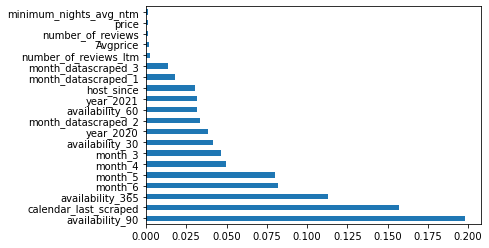

In [58]:
#Top 15 features in the 2020 model
feat_importances = pd.Series(final2020_model.feature_importances_, index=result.drop('future_bookings', axis = 1).columns)
feat_importances.nlargest(20).plot(kind='barh')

**Comparing the 2019 and 2020 model top features:** 
- One thing that is strikingly common between the two models is that time related features such as year,month,etc are the most important when it comes to predicting the bookings in both the years
- Although,in comparison one can see that in the 2020 model the future year variable i.e. year_2021 has lower predictability that the current year_2020 whereas in the 2019 model the future and current year variables year_2020 and year_2019 have almost the same level of importance
- It is also interesting to note that although the month_ features showed up as important in both the models, months 3,4,5 and 6 had consistently increasing impact on predictability on the 2020 dataset. This is an interesting in the context that lockdowns did start around March 2020 in Los angeles 


### 2.6 Next steps and improvements

Working with a large dataset had its own set of challenges(Mainly Time taken to build a model and RAM availability) even though I utilised Google cloud's Compute engine with infrastructure avaialable in the free tier to perform this analysis. In the future to improve upon this analysis I would look into the following approaches
- Utilise the historical Airbnb datasets available on Inside Airbnb website to do a better historical analysis
- Reduce the dataset size by using PCA to filter in only the most important features for predictability 